# Packages

In [1]:
# Data and Maths
import pandas as pd
import numpy as np
import math

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth, Circle, Marker, Icon
from folium.plugins import HeatMap, MarkerCluster

# Statistics
import scipy.stats as stats
from scipy.stats import binom, norm
import pymc as pm
import arviz as az
RANDOM_SEED = 42
import random

# Geocoding
import geopandas as gpd
from geopy.geocoders import Nominatim # For folium maps to return centering coordinates
import osmnx as ox # To return the geometry of a target region or city
import ssl # For the certificates to make the osmnx work
ssl._create_default_https_context = ssl._create_unverified_context

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Estimating vehicle adoption in LSOAs

Here, we use 2011 and 2021 census data to adjust vehicle registration data and quantify our uncertainty about the true underlying number of vehicles owned in a particular lower layer super output area (LSOA).

### Load 2011 Census data

In [2]:
def load_2011_census_data(file):
    df = pd.read_csv(file)

    # Rename columns
    df = df.rename(
        columns={
            'GEO_CODE':'LSOA11CD',
            'GEO_LABEL':'LSOA11NM',
            'Car or van availability : Sum of all cars or vans - Unit : Cars or vans':'number_of_cars',
            'Car or van availability : No cars or vans in household - Unit : Households':'households_wth_no_cars',
            'Car or van availability : Total\ Car or van availability - Unit : Households':'number_of_households',
        }
    )

    # Set index to LSOA11CD
    df = df.set_index('LSOA11CD', drop=False)

    # Set index name to None
    df.index.name = None

    # Extract data about the number of households with no cars
    households_with_no_cars = df['households_wth_no_cars']

    # Extract data about the number of households in each LSOA
    number_of_households = df['number_of_households']

    # Filter for relevant columns
    df = df[['LSOA11CD', 'LSOA11NM', 'number_of_cars']]

    return df, households_with_no_cars, number_of_households 

In [3]:
census_cars_and_vans_2011_df, census_households_with_no_cars_2011, census_number_of_households_2011 = load_2011_census_data('../../data/demographic_data/census_2011/LSOA_cars_and_vans.csv')

In [4]:
census_cars_and_vans_2011_df.head()

,LSOA11CD,LSOA11NM,number_of_cars
95AA01S1,95AA01S1,Aldergrove_1,389
95AA01S2,95AA01S2,Aldergrove_2,1122
95AA01S3,95AA01S3,Aldergrove_3,1012
95AA02W1,95AA02W1,Balloo,756
95AA03W1,95AA03W1,Ballycraigy,731


In [5]:
census_households_with_no_cars_2011.head()

95AA01S1     23
95AA01S2     44
95AA01S3     46
95AA02W1    287
95AA03W1    293
Name: households_wth_no_cars, dtype: int64

In [6]:
census_number_of_households_2011.head()

95AA01S1    310
95AA01S2    624
95AA01S3    588
95AA02W1    839
95AA03W1    845
Name: number_of_households, dtype: int64

### Load 2021 Census data

In [7]:
def load_2021_census_data(file):
    df_raw = pd.read_csv(file)

    # Since each availability code corresponds to the number of vehicles present at the recorded household, 
    # the number of cars and vans present in the LSOA can be approximated as the number of households that fall into a category, multiplied by the category code.
    df_raw['number_of_cars'] = df_raw['Observation'] * df_raw['Car or van availability (5 categories) Code']

    # Create a new compacted dataframe with the columns of interest
    df = pd.DataFrame(index=df_raw['Lower Layer Super Output Areas Code'].unique(), columns = ['LSOA21NM', 'number_of_cars'])

    # Populate columns
    df['LSOA21NM'] = df_raw['Lower Layer Super Output Areas'].unique()
    df['number_of_cars'] = df_raw.groupby('Lower Layer Super Output Areas Code')['number_of_cars'].sum()
    df['LSOA21CD'] = df.index

    return df_raw, df

In [8]:
raw_census_cars_and_vans_2021_df, census_cars_and_vans_2021_df = load_2021_census_data('../../data/demographic_data/census_2021/LSOA_car_or_van_availability.csv')

In [9]:
raw_census_cars_and_vans_2021_df.head(10)

,Lower Layer Super Output Areas Code,Lower Layer Super Output Areas,Car or van availability (5 categories) Code,Car or van availability (5 categories),Observation,number_of_cars
0,E01000001,City of London 001A,-8,Does not apply,0,0
1,E01000001,City of London 001A,0,No cars or vans in household,555,0
2,E01000001,City of London 001A,1,1 car or van in household,243,243
3,E01000001,City of London 001A,2,2 cars or vans in household,29,58
4,E01000001,City of London 001A,3,3 or more cars or vans in household,10,30
5,E01000002,City of London 001B,-8,Does not apply,0,0
6,E01000002,City of London 001B,0,No cars or vans in household,578,0
7,E01000002,City of London 001B,1,1 car or van in household,208,208
8,E01000002,City of London 001B,2,2 cars or vans in household,26,52
9,E01000002,City of London 001B,3,3 or more cars or vans in household,12,36


In [10]:
census_cars_and_vans_2021_df.head()

,LSOA21NM,number_of_cars,LSOA21CD
E01000001,City of London 001A,331,E01000001
E01000002,City of London 001B,296,E01000002
E01000003,City of London 001C,220,E01000003
E01000005,City of London 001E,119,E01000005
E01000006,Barking and Dagenham 016A,516,E01000006


### Filter data for local authority district (lad)

By restricting the area of interest, this speeds up the development of the modelling and analysis.

In [11]:
# Define lad of interest
lad = 'Bath and North East Somerset'

# Load LSOA lookup tables to help map LSOAs to lads as well as map between 2011 and 2021 LSOA codes.
lsoa_lookup = pd.read_csv('../../data/spatial_data/lsoa_data/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')
lsoa_lookup.head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM,LAD22NMW,ObjectId
0,E01000001,City of London 001A,E01000001,City of London 001A,U,E09000001,City of London,NaN,1
1,E01000002,City of London 001B,E01000002,City of London 001B,U,E09000001,City of London,NaN,2
2,E01000003,City of London 001C,E01000003,City of London 001C,U,E09000001,City of London,NaN,3
3,E01000005,City of London 001E,E01000005,City of London 001E,U,E09000001,City of London,NaN,4
4,E01000006,Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,U,E09000002,Barking and Dagenham,NaN,5


In [12]:
# Filter lookup table for LSOA within the target lad only
lad_lsoa_lookup = lsoa_lookup[lsoa_lookup['LAD22NM'] == lad]
lad_lsoa_lookup.head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM,LAD22NMW,ObjectId
13651,E01014373,Bath and North East Somerset 010A,E01014373,Bath and North East Somerset 010A,U,E06000022,Bath and North East Somerset,NaN,13652
13652,E01014428,Bath and North East Somerset 008B,E01014428,Bath and North East Somerset 008B,U,E06000022,Bath and North East Somerset,NaN,13653
13676,E01014479,Bath and North East Somerset 005C,E01014479,Bath and North East Somerset 005C,U,E06000022,Bath and North East Somerset,NaN,13677
13678,E01014429,Bath and North East Somerset 008C,E01014429,Bath and North East Somerset 008C,U,E06000022,Bath and North East Somerset,NaN,13679
13681,E01014374,Bath and North East Somerset 010B,E01014374,Bath and North East Somerset 010B,U,E06000022,Bath and North East Somerset,NaN,13682


In [13]:
# Merge census cars and van data with the filtered LSOA lookup data
lad_census_cars_vans_2021_df = census_cars_and_vans_2021_df.merge(lad_lsoa_lookup[['LSOA11CD', 'LSOA21CD']], on='LSOA21CD', how='right')

# Some new LSOAs were fromed in 2021 due to changes in population sizes. Many of these new 2021 LSOAs are a result of dividing a 2011 LSOA into two new LSOAs.
# Since the 2021 LSOAs share the same 2011 LSOA code, we sum their values. 
# This is easier than going the other way and mapping 2011 LSOAs to 2021 LSOAs
lad_census_cars_vans_2021_df['number_of_cars'] = lad_census_cars_vans_2021_df.groupby('LSOA11CD')['number_of_cars'].transform('sum')

# Drop duplicate LSOAs
lad_census_cars_vans_2021_df = lad_census_cars_vans_2021_df.drop_duplicates(subset=['LSOA11CD']).drop(columns=['LSOA21CD'])

# Set index to LSOA11CD
lad_census_cars_vans_2021_df = lad_census_cars_vans_2021_df.set_index('LSOA11CD', drop=False)

lad_census_cars_vans_2021_df.head()

,LSOA21NM,number_of_cars,LSOA11CD
LSOA11CD,,,
E01014373,Bath and North East Somerset 010A,863,E01014373
E01014428,Bath and North East Somerset 008B,663,E01014428
E01014479,Bath and North East Somerset 005C,741,E01014479
E01014429,Bath and North East Somerset 008C,776,E01014429
E01014374,Bath and North East Somerset 010B,895,E01014374


In [14]:
# Filter LSOAs that are contained within the target lad
lad_census_cars_vans_2011_df = census_cars_and_vans_2011_df.loc[lad_lsoa_lookup['LSOA11CD'].values]

# Drop duplicate LSOAs
lad_census_cars_vans_2011_df = lad_census_cars_vans_2011_df.drop_duplicates(subset=['LSOA11CD'])

# Set index to LSOA11CD
lad_census_cars_vans_2011_df = lad_census_cars_vans_2011_df.set_index('LSOA11CD', drop=False)

lad_census_cars_vans_2011_df.head()

,LSOA11CD,LSOA11NM,number_of_cars
LSOA11CD,,,
E01014373,E01014373,Bath and North East Somerset 010A,825
E01014428,E01014428,Bath and North East Somerset 008B,727
E01014479,E01014479,Bath and North East Somerset 005C,804
E01014429,E01014429,Bath and North East Somerset 008C,761
E01014374,E01014374,Bath and North East Somerset 010B,796


### Load vehicle registration data

This data is from the UK Department for Transport.

In [15]:
# apply_dtypes is a convenience function that converts select columns from str to float values
def apply_dtypes(first, last):
    dtypes = {i: str for i in range(first)}  # first 'first' columns as strings
    dtypes.update({i: float for i in range(first, last)}) # 'last' columns is currently hard coded. Float is needed for NaNs
    return dtypes

Car registration data

In [16]:
car_registrations_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0125.csv', dtype = apply_dtypes(5, 57), na_values=['[c]', '[x]'])
    .query("BodyType == 'Cars' & Keepership == 'Private' & LicenceStatus == 'Licensed'") # Filter for liscenced, private cars
    .drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == lad] # Filter for target Local Authority District
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
car_registrations_lsoa = car_registrations_lsoa[~car_registrations_lsoa.index.duplicated(keep='first')]

car_registrations_lsoa.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,359.0,361.0,353.0,357.0,352.0,369.0,390.0,382.0,380.0,371.0,...,390.0,397.0,391.0,393.0,384.0,389.0,406.0,378.0,384.0,386.0
E01014371,509.0,502.0,512.0,507.0,524.0,517.0,524.0,524.0,530.0,523.0,...,537.0,552.0,546.0,557.0,552.0,540.0,538.0,549.0,547.0,557.0
E01014372,494.0,495.0,507.0,506.0,509.0,513.0,508.0,506.0,508.0,500.0,...,548.0,553.0,556.0,552.0,571.0,561.0,588.0,604.0,595.0,591.0
E01014373,762.0,753.0,754.0,770.0,768.0,775.0,762.0,773.0,740.0,749.0,...,680.0,674.0,690.0,688.0,695.0,692.0,684.0,696.0,692.0,703.0
E01014374,740.0,752.0,762.0,759.0,756.0,746.0,750.0,741.0,739.0,727.0,...,632.0,627.0,632.0,637.0,634.0,633.0,637.0,628.0,627.0,641.0


Other vehicle body types (excl. Motorbikes) registration data

In [17]:
other_registrations_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0125.csv', dtype = apply_dtypes(5, 57), na_values=['[c]', '[x]'])
    .query("BodyType == 'Other body types' & Keepership == 'Private' & LicenceStatus == 'Licensed'")
    .drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == lad] # Filter for target Local Authority District
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
other_registrations_lsoa = other_registrations_lsoa[~other_registrations_lsoa.index.duplicated(keep='first')]

other_registrations_lsoa.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,32.0,29.0,30.0,30.0,32.0,30.0,35.0,36.0,34.0,37.0,...,40.0,40.0,42.0,41.0,36.0,43.0,40.0,38.0,39.0,40.0
E01014371,24.0,22.0,22.0,20.0,22.0,21.0,21.0,22.0,25.0,29.0,...,25.0,24.0,26.0,25.0,28.0,29.0,27.0,26.0,26.0,28.0
E01014372,17.0,18.0,20.0,22.0,18.0,21.0,22.0,25.0,26.0,31.0,...,43.0,41.0,42.0,43.0,41.0,43.0,46.0,43.0,41.0,39.0
E01014373,103.0,105.0,110.0,109.0,106.0,105.0,108.0,109.0,102.0,111.0,...,97.0,93.0,90.0,91.0,92.0,96.0,96.0,99.0,95.0,95.0
E01014374,65.0,65.0,64.0,68.0,65.0,64.0,61.0,64.0,62.0,64.0,...,42.0,41.0,43.0,45.0,47.0,46.0,48.0,50.0,48.0,46.0


In [18]:
# Combine both car registrations and other body type registrations
registered_vehicles_lsoa = car_registrations_lsoa + other_registrations_lsoa
registered_vehicles_lsoa.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,391.0,390.0,383.0,387.0,384.0,399.0,425.0,418.0,414.0,408.0,...,430.0,437.0,433.0,434.0,420.0,432.0,446.0,416.0,423.0,426.0
E01014371,533.0,524.0,534.0,527.0,546.0,538.0,545.0,546.0,555.0,552.0,...,562.0,576.0,572.0,582.0,580.0,569.0,565.0,575.0,573.0,585.0
E01014372,511.0,513.0,527.0,528.0,527.0,534.0,530.0,531.0,534.0,531.0,...,591.0,594.0,598.0,595.0,612.0,604.0,634.0,647.0,636.0,630.0
E01014373,865.0,858.0,864.0,879.0,874.0,880.0,870.0,882.0,842.0,860.0,...,777.0,767.0,780.0,779.0,787.0,788.0,780.0,795.0,787.0,798.0
E01014374,805.0,817.0,826.0,827.0,821.0,810.0,811.0,805.0,801.0,791.0,...,674.0,668.0,675.0,682.0,681.0,679.0,685.0,678.0,675.0,687.0


To compare vehicle registrations and census data taken in the same year, we take a mean of the four quarters for the vehicle registration data.

In [19]:
lad_census_cars_vans_2011_df['registered_vehicles'] = registered_vehicles_lsoa.loc[:, ['2011 Q1', '2011 Q2', '2011 Q3', '2011 Q4']].mean(axis=1).round()
lad_census_cars_vans_2011_df.head()

,LSOA11CD,LSOA11NM,number_of_cars,registered_vehicles
LSOA11CD,,,,
E01014373,E01014373,Bath and North East Somerset 010A,825,778.0
E01014428,E01014428,Bath and North East Somerset 008B,727,634.0
E01014479,E01014479,Bath and North East Somerset 005C,804,714.0
E01014429,E01014429,Bath and North East Somerset 008C,761,727.0
E01014374,E01014374,Bath and North East Somerset 010B,796,676.0


In [20]:
lad_census_cars_vans_2021_df['registered_vehicles'] = registered_vehicles_lsoa.loc[:, ['2021 Q1', '2021 Q2', '2021 Q3', '2021 Q4']].mean(axis=1).round()
lad_census_cars_vans_2021_df.head()

,LSOA21NM,number_of_cars,LSOA11CD,registered_vehicles
LSOA11CD,,,,
E01014373,Bath and North East Somerset 010A,863,E01014373,868.0
E01014428,Bath and North East Somerset 008B,663,E01014428,630.0
E01014479,Bath and North East Somerset 005C,741,E01014479,724.0
E01014429,Bath and North East Somerset 008C,776,E01014429,736.0
E01014374,Bath and North East Somerset 010B,895,E01014374,807.0


### Plot Census vs Registration Data

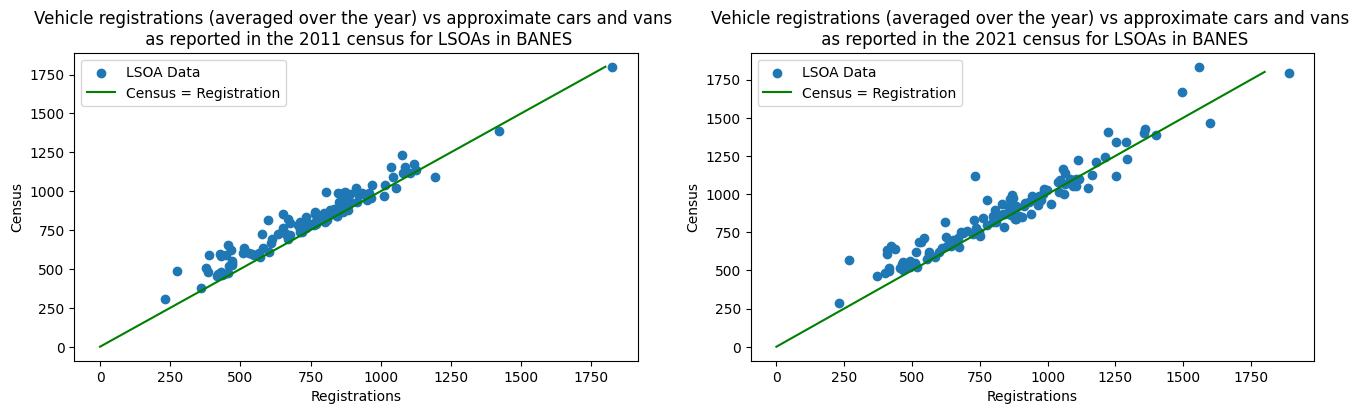

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# 2011
ax[0].scatter(x=lad_census_cars_vans_2011_df['registered_vehicles'], y=lad_census_cars_vans_2011_df['number_of_cars'], label='LSOA Data')
ax[0].plot(np.linspace(0, 1800), np.linspace(0, 1800), color='green', label='Census = Registration')
ax[0].set_xlabel('Registrations')
ax[0].set_ylabel('Census')
ax[0].set_title('Vehicle registrations (averaged over the year) vs approximate cars and vans \n as reported in the 2011 census for LSOAs in BANES')
ax[0].legend()

# 2021
ax[1].scatter(x=lad_census_cars_vans_2021_df['registered_vehicles'], y=lad_census_cars_vans_2021_df['number_of_cars'], label='LSOA Data')
ax[1].plot(np.linspace(0, 1800), np.linspace(0, 1800), color='green', label='Census = Registration')
ax[1].set_xlabel('Registrations')
ax[1].set_ylabel('Census')
ax[1].set_title('Vehicle registrations (averaged over the year) vs approximate cars and vans \n as reported in the 2021 census for LSOAs in BANES')

ax[1].legend()
plt.show()

### Calculate the relative difference between census data and vehicle registration data

This is the difference relative to the vehicle registration data. How much larger or smaller is the census data, relative to the number of vehicle registrations?

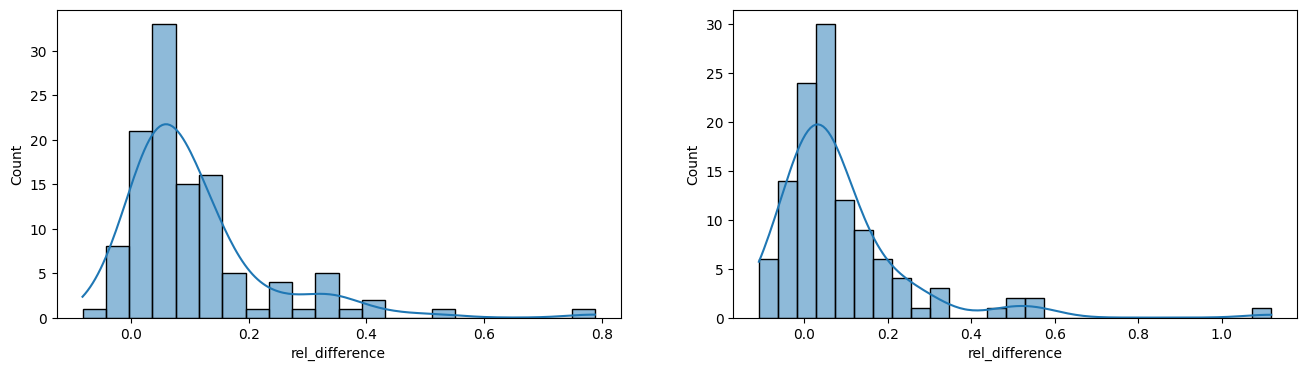

In [22]:
# Calculate the absolute differences for 2011 and 2021
lad_census_cars_vans_2011_df['abs_difference'] = lad_census_cars_vans_2011_df['number_of_cars'] - lad_census_cars_vans_2011_df['registered_vehicles']
lad_census_cars_vans_2021_df['abs_difference'] = lad_census_cars_vans_2021_df['number_of_cars'] - lad_census_cars_vans_2021_df['registered_vehicles']

# Use the absolute difference to calculate the relative differences
lad_census_cars_vans_2011_df['rel_difference'] = lad_census_cars_vans_2011_df['abs_difference'] / lad_census_cars_vans_2011_df['registered_vehicles']
lad_census_cars_vans_2021_df['rel_difference'] = lad_census_cars_vans_2021_df['abs_difference'] / lad_census_cars_vans_2021_df['registered_vehicles']

fig, ax = plt.subplots(1, 2, figsize=(16,4))

sns.histplot(ax = ax[0], data = lad_census_cars_vans_2011_df['rel_difference'], kde=True)
sns.histplot(ax = ax[1], data = lad_census_cars_vans_2021_df['rel_difference'], kde=True)
plt.show()

### Model the relative difference with PyMC

In [23]:
# Create DataFrames from the Series
rel_diff_2011 = pd.DataFrame({'LSOA11CD': lad_census_cars_vans_2011_df['rel_difference'].index, 'year': 2011, 'rel_diff': lad_census_cars_vans_2011_df['rel_difference'].values})
rel_diff_2021 = pd.DataFrame({'LSOA11CD': lad_census_cars_vans_2021_df['rel_difference'].index, 'year': 2021, 'rel_diff': lad_census_cars_vans_2021_df['rel_difference'].values})

# Concatenate the two DataFrames
rel_diff = pd.concat([rel_diff_2011, rel_diff_2021], ignore_index=True).sort_values(by='LSOA11CD').reset_index(drop=True)
rel_diff.head()

,LSOA11CD,year,rel_diff
0,E01014370,2021,0.205314
1,E01014370,2011,0.116009
2,E01014371,2021,0.304029
3,E01014371,2011,0.250865
4,E01014372,2021,0.289474


In [24]:
coords = {"LSOA": rel_diff.LSOA11CD.unique().tolist()}
lsoa = np.repeat(np.arange(len(rel_diff.LSOA11CD.unique())), 2)

In [25]:
with pm.Model(coords=coords) as hierarchical_model:
    lsoa_idx = pm.MutableData("lsoa_idx", lsoa, dims="obs_id")
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0, sigma=1)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    
    # Random intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, dims='LSOA')

    # Model error
    sigma_y = pm.Exponential("sigma_y", 0.5)

    # Expected value
    y_hat = alpha[lsoa_idx]
    
    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=rel_diff.rel_diff.values, dims="obs_id")

# Sample from the model
with hierarchical_model:
    trace = pm.sample(2000, tune=1000, cores=4, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, alpha, sigma_y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_y'}>,
        <Axes: title={'center': 'sigma_y'}>]], dtype=object)

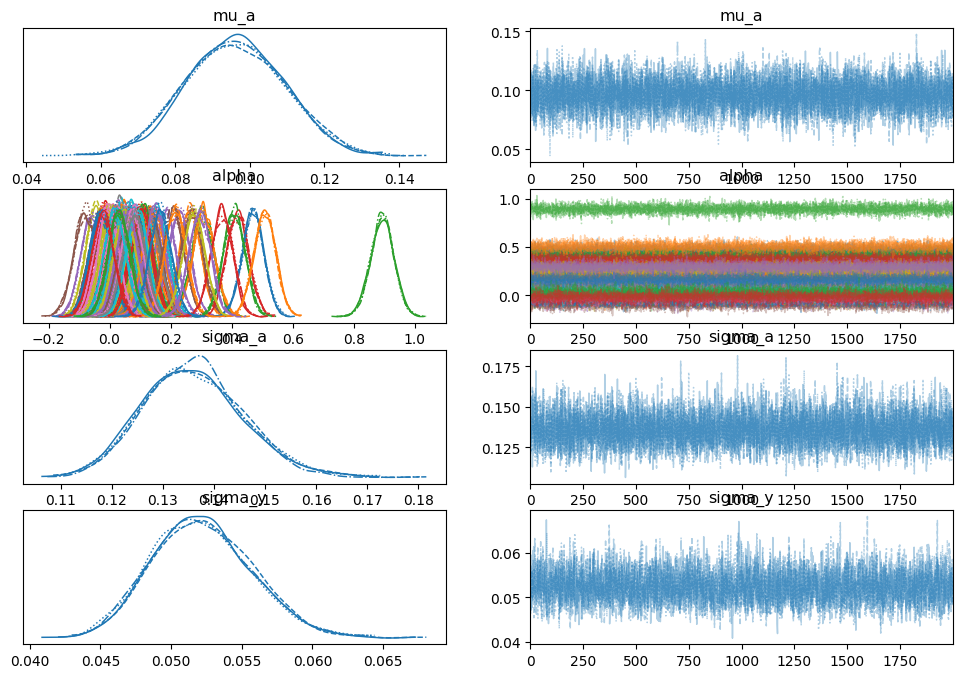

In [26]:
az.plot_trace(trace)

Text(0, 0.5, 'alpha')

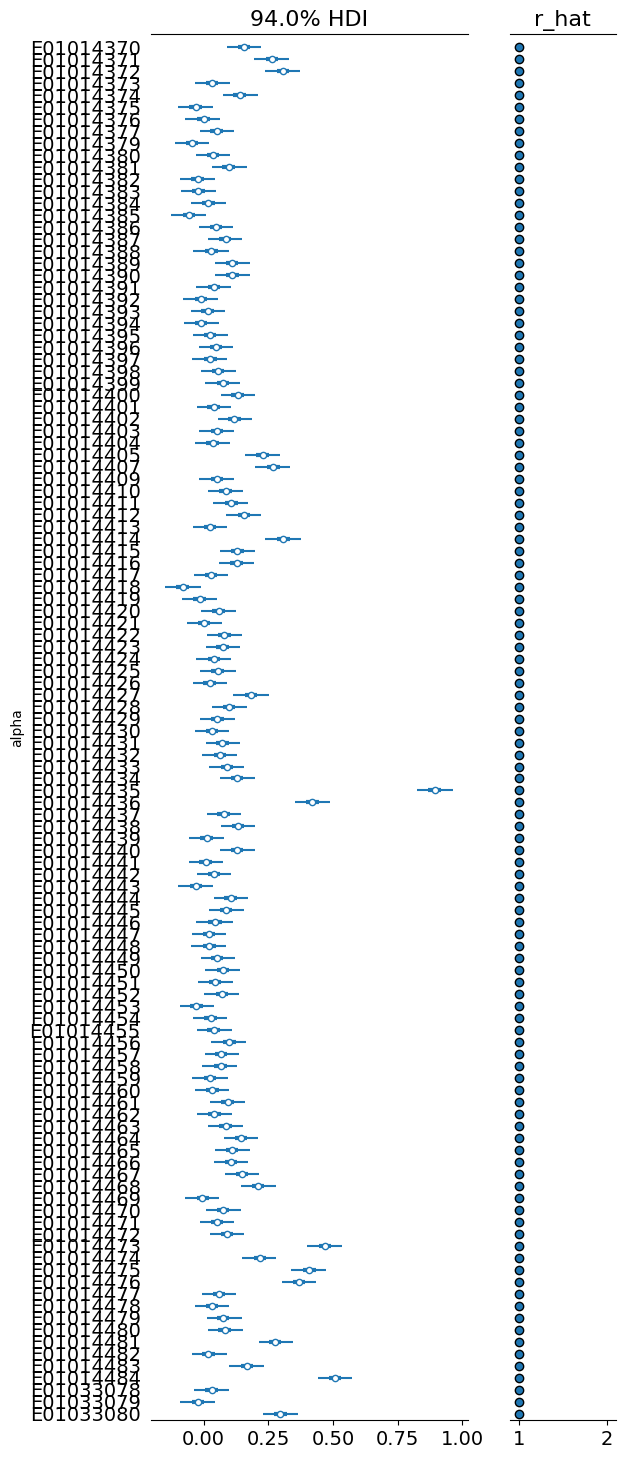

In [27]:
ax = pm.plot_forest(
    trace,
    var_names=["alpha"],
    figsize=(6, 18),
    combined=True,
    r_hat=True,
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha")

In [28]:
target_lsoa = rel_diff.LSOA11CD.unique()[4]
target_lsoa

'E01014374'

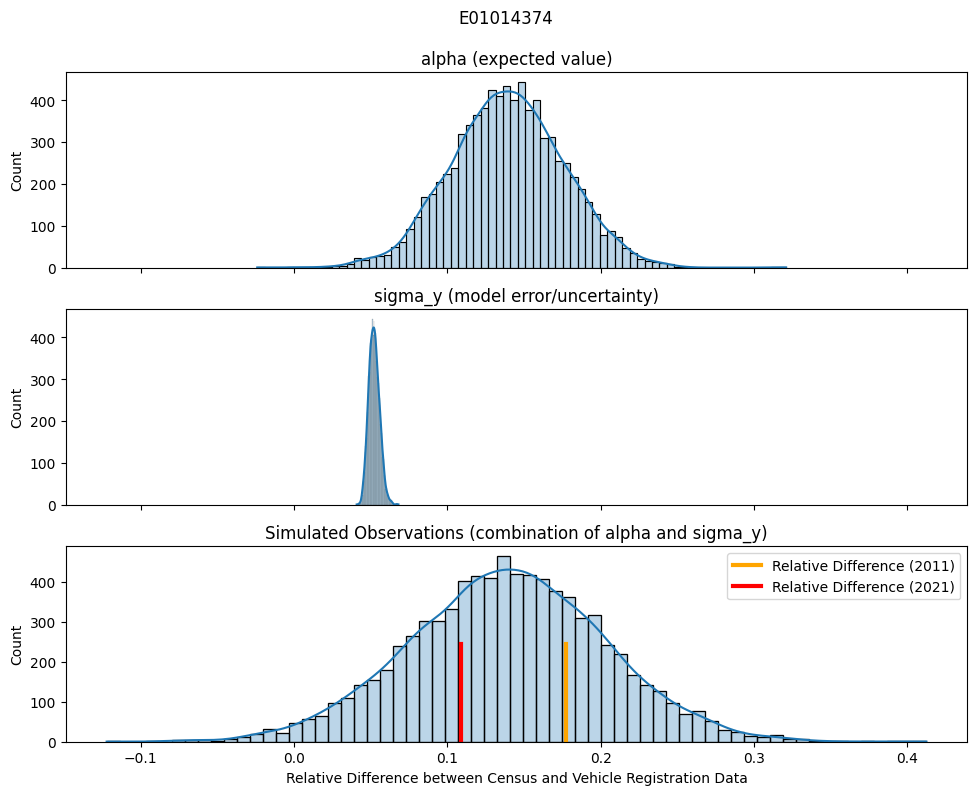

In [29]:
alpha = trace.posterior.sel(LSOA=target_lsoa).alpha.stack(combined=('chain', 'draw')).to_numpy()
sigma_y = trace.posterior.sel(LSOA=target_lsoa).sigma_y.stack(combined=('chain', 'draw')).to_numpy()
simulated_observations = alpha + np.random.normal(0, sigma_y)

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
fig.suptitle(target_lsoa)
fig.tight_layout(pad=2.0)
plt.xlabel('Relative Difference between Census and Vehicle Registration Data')

sns.histplot(alpha, kde=True, ax=axes[0], alpha=0.3)
axes[0].set_title('alpha (expected value)')

sns.histplot(sigma_y, kde=True, ax=axes[1], alpha=0.3)
axes[1].set_title('sigma_y (model error/uncertainty)')

sns.histplot(simulated_observations, kde=True, ax=axes[2], alpha=0.3)
axes[2].set_title('Simulated Observations (combination of alpha and sigma_y)')
axes[2].axvline(rel_diff.loc[rel_diff['LSOA11CD'] == target_lsoa, 'rel_diff'].values[0], 0, 0.5, color='orange', linewidth=3, label='Relative Difference (2011)')
axes[2].axvline(rel_diff.loc[rel_diff['LSOA11CD'] == target_lsoa, 'rel_diff'].values[1], 0, 0.5, color='red', linewidth=3, label='Relative Difference (2021)')

plt.legend()
plt.show()

Use this to adjust estimates for the number of vehicles owned in a particular LSOA

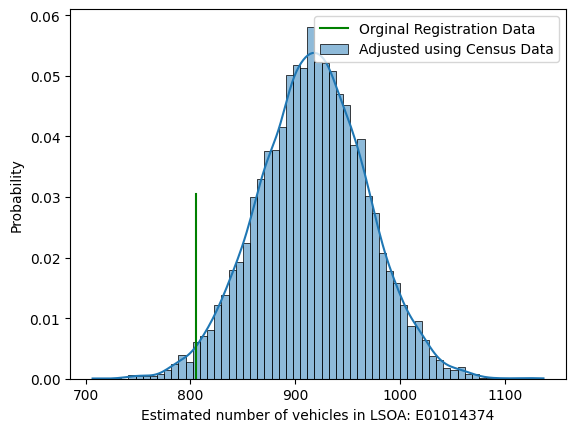

In [30]:
sns.histplot(registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations), kde=True, label='Adjusted using Census Data', stat='probability')
plt.axvline(registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'], 0, 0.5, color='green', label='Orginal Registration Data')
plt.xlabel('Estimated number of vehicles in LSOA: {}'.format(target_lsoa))
plt.legend()
plt.show()

In [31]:
def estimate_vehicles_multiple_lsoas(target_lsoas):

    est_vehicles = {}
    for target_lsoa in target_lsoas:
        alpha = trace.posterior.sel(LSOA=target_lsoa).alpha.stack(combined=('chain', 'draw')).to_numpy()
        sigma_y = trace.posterior.sel(LSOA=target_lsoa).sigma_y.stack(combined=('chain', 'draw')).to_numpy()
        simulated_observations = alpha + np.random.normal(0, sigma_y)

        est_vehicles[target_lsoa] = (registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations)).round(0)

    est_vehicles_df = pd.DataFrame(est_vehicles)

    return est_vehicles_df

In [32]:
est_vehicles_lsoa_df = estimate_vehicles_multiple_lsoas(registered_vehicles_lsoa.index.values.tolist())
est_vehicles_lsoa_df.head()

,E01014370,E01014371,E01014372,E01014373,E01014374,E01014375,E01014376,E01014377,E01014379,E01014380,...,E01014478,E01014479,E01014480,E01014481,E01014482,E01014483,E01014484,E01033078,E01033079,E01033080
0,444.0,702.0,689.0,899.0,904.0,1042.0,1119.0,875.0,1427.0,864.0,...,478.0,790.0,580.0,517.0,688.0,482.0,648.0,1171.0,864.0,825.0
1,453.0,639.0,658.0,898.0,861.0,900.0,1029.0,772.0,1412.0,781.0,...,571.0,893.0,699.0,518.0,704.0,558.0,658.0,1128.0,986.0,882.0
2,489.0,658.0,677.0,873.0,918.0,923.0,1016.0,847.0,1488.0,773.0,...,533.0,821.0,601.0,497.0,672.0,556.0,648.0,1189.0,842.0,812.0
3,411.0,677.0,721.0,786.0,977.0,954.0,1077.0,909.0,1670.0,772.0,...,441.0,750.0,635.0,441.0,676.0,551.0,613.0,1162.0,875.0,833.0
4,464.0,692.0,642.0,999.0,927.0,900.0,1189.0,861.0,1435.0,799.0,...,597.0,785.0,572.0,485.0,690.0,488.0,661.0,1226.0,853.0,830.0


# Estimating EV adoption in LSOAs

### Convenience Functions

In [33]:
# mask is a way of filtering a dataframe in a chained way
def mask(df, key, value):
    return df[df[key] == value]

pd.DataFrame.mask = mask

# apply_dtypes converts select columns from str to float values
def apply_dtypes(first, last):
    dtypes = {i: str for i in range(first)}  # first 'first' columns as strings
    dtypes.update({i: float for i in range(first, last)}) # 'last' columns is currently hard coded. Float is needed for NaNs
    return dtypes

# Returns the first (and oldest) date (assuming date is the index) of a series or DataFrame
def calculate_t0(data):
    year = int(data.head(1).index[0][:4])
    quarter = data.head(1).index[0][-2:]
    if quarter == 'Q1':
        t0 = year + 0
    elif quarter == 'Q2':
        t0 = year + 0.25
    elif quarter == 'Q3':
        t0 = year + 0.5
    elif quarter == 'Q4':
        t0 = year + 0.75
    return t0

# Returns the last (and most recent) date (assuming date is the index) of a series or DataFrame
def calculate_t_present(data):
    year = int(data.tail(1).index[0][:4])
    quarter = data.tail(1).index[0][-2:]
    if quarter == 'Q1':
        t_present = year + 0
    elif quarter == 'Q2':
        t_present = year + 0.25
    elif quarter == 'Q3':
        t_present = year + 0.5
    elif quarter == 'Q4':
        t_present = year + 0.75    
    return t_present

# Returns an array of numeric dates between t0 and t1 at a specified sample rate
def calculate_date_range(t0, t1, sample_rate):
    return np.linspace(t0, t1, int((t1-t0)*sample_rate) + 1)

# Takes in text based dates (e.g. 2022 Q4) and returns an array of decimalised dates
def convert_dates_to_numeric(data):
    dates = np.zeros(len(data))
    for i in np.arange(len(data)):
        year = int(data.index[i][:4])
        quarter = data.index[i][-2:]
        if quarter == 'Q1':
            d = year + 0
        elif quarter == 'Q2':
            d = year + 0.25
        elif quarter == 'Q3':
            d = year + 0.5
        elif quarter == 'Q4':
            d = year + 0.75
        dates[i] = d
    return dates

### Load EV registration data

In [34]:
ev_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0145.csv', dtype = apply_dtypes(4, 56), na_values=['[c]', '[x]'])
    .query("Keepership == 'Private'")
    .drop(columns = ['Keepership', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == lad]
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

ev_lsoa.head()

,Fuel,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,Battery electric,10.0,9.0,8.0,7.0,8.0,8.0,6.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014370,Plug-in hybrid electric (petrol),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014370,Total,14.0,13.0,12.0,10.0,11.0,11.0,8.0,6.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,Battery electric,8.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014371,Plug-in hybrid electric (diesel),NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
bev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Battery electric' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
bev_lsoa = bev_lsoa[~bev_lsoa.index.duplicated(keep='first')]

bev_lsoa.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,10.0,9.0,8.0,7.0,8.0,8.0,6.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014371,8.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,8.0,7.0,5.0,5.0,5.0,NaN,5.0,5.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,13.0,10.0,12.0,11.0,11.0,11.0,9.0,7.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,20.0,20.0,17.0,18.0,18.0,15.0,15.0,10.0,8.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
phev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Plug-in hybrid electric (petrol)' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
phev_lsoa = phev_lsoa[~phev_lsoa.index.duplicated(keep='first')]

phev_lsoa.head()

,2023 Q1,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,6.0,5.0,NaN,NaN,NaN,NaN,6.0,5.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,11.0,12.0,11.0,10.0,9.0,8.0,7.0,5.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Interpolate missing registration data

In [37]:
# Interpolates missing registration data
def interpolate_registration_data(data, sample_rate):
    def interpolate_col(col):
        dates = calculate_date_range(calculate_t0(col), calculate_t_present(col), sample_rate)
        mask = ~col.isna().values
        if mask.any():
            xp = dates[mask]
            fp = col[mask]
            x = dates
            interpolated = np.round(np.interp(x, xp, fp))
            return pd.Series(data=interpolated, index=col.index)
        else:
            return pd.Series(data=np.nan, index=col.index)
    
    interpolated_df = data.apply(interpolate_col, axis=0)

    interpolated_df = interpolated_df.fillna(0)
    
    return interpolated_df

In [38]:
sample_rate = 4 # Quarterly

bev_lsoa_i = interpolate_registration_data(bev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
phev_lsoa_i = interpolate_registration_data(phev_lsoa.T.iloc[::-1], sample_rate=sample_rate)

### Sample from model posterial distribution and simulate plausable observations

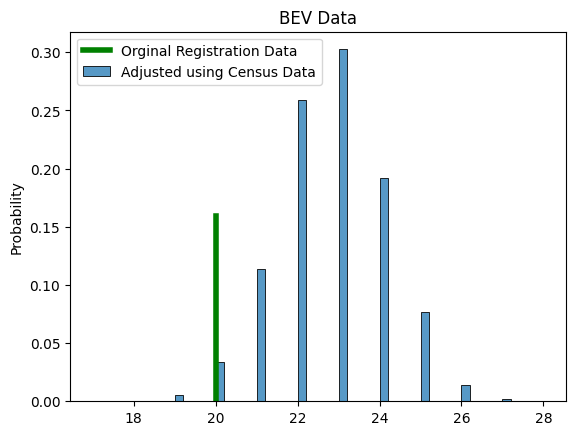

In [39]:
alpha = trace.posterior.sel(LSOA=target_lsoa).alpha.stack(combined=('chain', 'draw')).to_numpy()
sigma_y = trace.posterior.sel(LSOA=target_lsoa).sigma_y.stack(combined=('chain', 'draw')).to_numpy()
simulated_observations = alpha + np.random.normal(0, sigma_y)

sns.histplot((bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).round(0), label='Adjusted using Census Data', stat='probability')
plt.axvline(bev_lsoa_i.loc['2023 Q1', target_lsoa], 0, 0.5, color='green', label='Orginal Registration Data', linewidth=4)
plt.legend()
plt.title('BEV Data')
plt.show()

In [40]:
def estimate_evs_multiple_lsoas(target_lsoas, ev_data):
    est_vehicles = {}
    for lsoa in target_lsoas:
        alpha = trace.posterior.sel(LSOA=lsoa).alpha.stack(combined=('chain', 'draw')).to_numpy()
        sigma_y = trace.posterior.sel(LSOA=lsoa).sigma_y.stack(combined=('chain', 'draw')).to_numpy()
        simulated_observations = alpha + np.random.normal(0, sigma_y)

        est_vehicles[lsoa] = (ev_data.loc['2023 Q1', lsoa] * (1 + simulated_observations)).round(0)

    est_vehicles_df = pd.DataFrame(est_vehicles)

    return est_vehicles_df

In [41]:
est_bevs_lsoa_df = estimate_evs_multiple_lsoas(bev_lsoa.index.values.tolist(), bev_lsoa_i)
est_bevs_lsoa_df.head()

,E01014370,E01014371,E01014372,E01014373,E01014374,E01014375,E01014376,E01014377,E01014379,E01014380,...,E01033079,E01033080,E01014431,E01014435,E01014458,E01014461,E01014462,E01014463,E01014473,E01014474
0,11.0,10.0,11.0,15.0,24.0,33.0,23.0,25.0,15.0,37.0,...,15.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.0,10.0,9.0,15.0,19.0,32.0,19.0,22.0,17.0,37.0,...,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.0,10.0,10.0,13.0,20.0,27.0,22.0,24.0,16.0,38.0,...,15.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.0,11.0,10.0,13.0,21.0,34.0,21.0,26.0,17.0,39.0,...,15.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.0,10.0,10.0,13.0,23.0,30.0,20.0,23.0,17.0,35.0,...,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
est_phevs_lsoa_df = estimate_evs_multiple_lsoas(phev_lsoa.index.values.tolist(), phev_lsoa_i)
est_phevs_lsoa_df.head()

,E01014370,E01014371,E01014372,E01014373,E01014374,E01014375,E01014376,E01014377,E01014379,E01014380,...,E01033079,E01033080,E01014431,E01014435,E01014458,E01014461,E01014462,E01014463,E01014473,E01014474
0,0.0,6.0,8.0,0.0,14.0,21.0,16.0,13.0,20.0,25.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,6.0,7.0,0.0,12.0,20.0,13.0,12.0,22.0,24.0,...,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,6.0,9.0,0.0,11.0,21.0,15.0,12.0,21.0,26.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,6.0,8.0,0.0,12.0,21.0,13.0,13.0,20.0,26.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,6.0,8.0,0.0,13.0,22.0,14.0,13.0,21.0,25.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Estimating on-plot parking access in LSOAs

### Load housing and accommodation data

In [43]:
house_lsoa = (
    pd.read_csv('../../data/demographic_data/census_2021/LSOA_households.csv')
    .rename(columns={'Lower layer Super Output Areas Code':'LSOA21CD', 'Lower layer Super Output Areas':'LSOA21NM', 'Observation':'N_households'})
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LSOA21CD', 'LAD22NM']], on = 'LSOA21CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == lad]
    .drop(columns=['LAD22NM', 'LSOA21NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
house_lsoa = house_lsoa[~house_lsoa.index.duplicated(keep='first')]

house_lsoa.head()

,LSOA21CD,N_households
LSOA11CD,,
E01014370,E01014370,1009
E01014371,E01014371,1044
E01014372,E01014372,1043
E01014373,E01014373,659
E01014374,E01014374,666


In [44]:
accommodation_type_lsoa = (
    pd.read_csv('../../data/demographic_data/census_2021/LSOA_accommodation_type.csv')
    .rename(columns={'Lower layer Super Output Areas Code':'LSOA21CD', 'Lower layer Super Output Areas':'LSOA21NM', 'Accommodation type (8 categories)':'Accommodation_type'})
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LSOA21CD', 'LAD22NM']], on = 'LSOA21CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == lad]
    .drop(columns=['LAD22NM', 'LSOA21NM', 'Accommodation type (8 categories) Code'])
    .set_index('LSOA11CD')
)

accommodation_type_lsoa.head()

,LSOA21CD,Accommodation_type,Observation
LSOA11CD,,,
E01014370,E01014370,Detached,15
E01014370,E01014370,Semi-detached,35
E01014370,E01014370,Terraced,61
E01014370,E01014370,In a purpose-built block of flats or tenement,507
E01014370,E01014370,"Part of a converted or shared house, including...",134


### Reformat accommodation type data

In [45]:
accommodation_type_lsoa.Accommodation_type.unique()

array(['Detached', 'Semi-detached', 'Terraced',
       'In a purpose-built block of flats or tenement',
       'Part of a converted or shared house, including bedsits',
       'Part of another converted building, for example, former school, church or warehouse',
       'In a commercial building, for example, in an office building, hotel or over a shop',
       'A caravan or other mobile or temporary structure'], dtype=object)

In [46]:
detached_lsoa = accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'Detached']['Observation']
detached_lsoa.name = 'detached'

semi_detached_lsoa = accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'Semi-detached']['Observation']
semi_detached_lsoa.name = 'semi_detached'

terraced_lsoa = accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'Terraced']['Observation']
terraced_lsoa.name = 'terraced'

purpose_built_flat_lsoa = accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'In a purpose-built block of flats or tenement']['Observation']
purpose_built_flat_lsoa.name = 'purpose_built_flat'

converted_flat_lsoa = (accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'Part of a converted or shared house, including bedsits']['Observation'] +
                        accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'Part of another converted building, for example, former school, church or warehouse']['Observation'] +
                        accommodation_type_lsoa[accommodation_type_lsoa['Accommodation_type'] == 'In a commercial building, for example, in an office building, hotel or over a shop']['Observation']
)
converted_flat_lsoa.name = 'converted_flat'

accommodation_type_proportions_lsoa = pd.concat([detached_lsoa, semi_detached_lsoa, terraced_lsoa, purpose_built_flat_lsoa, converted_flat_lsoa], axis=1)
accommodation_type_proportions_lsoa = accommodation_type_proportions_lsoa.div(accommodation_type_proportions_lsoa.sum(axis=1), axis=0)

# Drop duplicate rows
accommodation_type_proportions_lsoa = accommodation_type_proportions_lsoa[~accommodation_type_proportions_lsoa.index.duplicated(keep='first')]

accommodation_type_lsoa = round(accommodation_type_proportions_lsoa.mul(house_lsoa['N_households'], axis=0))
accommodation_type_lsoa['total'] = accommodation_type_lsoa.sum(axis=1)
accommodation_type_lsoa.head()

,detached,semi_detached,terraced,purpose_built_flat,converted_flat,total
LSOA11CD,,,,,,
E01014370,15.0,35.0,61.0,507.0,391.0,1009.0
E01014371,17.0,46.0,71.0,354.0,556.0,1044.0
E01014372,13.0,19.0,152.0,283.0,576.0,1043.0
E01014373,94.0,170.0,337.0,29.0,28.0,658.0
E01014374,232.0,196.0,152.0,62.0,24.0,666.0


### Estimating parking availability by accommodation type

This data is taken from the English Housing Survey 2021.

In the English Housing Survey, there were 1081 end terraces and 1790 mid terraces. 

Ratios are: 0.3765 and 0.6235

In [47]:
on_plot_parking_availability = {
    'end_terraced': 0.505,
    'mid_terraced': 0.338,
    'semi_detached': 0.822,
    'detached': 0.961,
    'converted_flat': 0.289,
    'purpose_built_flat': 0.256
}

on_plot_parking_availability['terraced'] = round(0.3765*on_plot_parking_availability['end_terraced'] + 0.6235*on_plot_parking_availability['mid_terraced'], 3)
del on_plot_parking_availability['end_terraced']
del on_plot_parking_availability['mid_terraced']

on_plot_parking_availability

{'semi_detached': 0.822,
 'detached': 0.961,
 'converted_flat': 0.289,
 'purpose_built_flat': 0.256,
 'terraced': 0.401}

In [48]:
on_plot_parking_availability_series = pd.Series(on_plot_parking_availability)
on_plot_parking_availability_series

semi_detached         0.822
detached              0.961
converted_flat        0.289
purpose_built_flat    0.256
terraced              0.401
dtype: float64

In [49]:
on_plot_parking_availability_by_accommodation_type = accommodation_type_lsoa.mul(on_plot_parking_availability_series, axis=1)
on_plot_parking_availability_by_accommodation_type['total'] = on_plot_parking_availability_by_accommodation_type.sum(axis=1)
on_plot_parking_availability_by_accommodation_type = round(on_plot_parking_availability_by_accommodation_type)
on_plot_parking_availability_by_accommodation_type.head()

,converted_flat,detached,purpose_built_flat,semi_detached,terraced,total
LSOA11CD,,,,,,
E01014370,113.0,14.0,130.0,29.0,24.0,310.0
E01014371,161.0,16.0,91.0,38.0,28.0,334.0
E01014372,166.0,12.0,72.0,16.0,61.0,328.0
E01014373,8.0,90.0,7.0,140.0,135.0,381.0
E01014374,7.0,223.0,16.0,161.0,61.0,468.0


In [50]:
# on_plot_parking_availability_by_accommodation_type['LSOA11CD'] = on_plot_parking_availability_by_accommodation_type.index
# on_plot_parking_availability_by_accommodation_type.head()

### Accounting for Uncertainty in on-plot parking estimates

In [175]:
n_samples = 10000

In [176]:
def calculate_n_on_plot_parking(target_lsoa, n_samples):
    n_on_plot_parking = np.sum(

        # Assume a binomial distribution describes the spread of the likely numbers of houses of a given accommodation type with on-plot parking.
        binom.rvs(
            n=[accommodation_type_lsoa.loc[target_lsoa].loc[x].astype(int) for x in on_plot_parking_availability_series.index.values], 
            p=on_plot_parking_availability_series.values.tolist(),
            size=(n_samples, 5)
        ),
        axis=1
    )
    return n_on_plot_parking

Text(0.5, 1.0, 'Estimated number of houses with off-street residential parking spaces in LSOA E01014374')

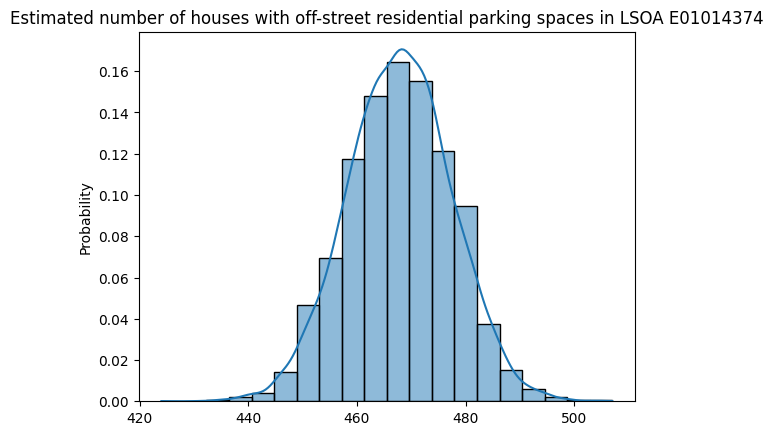

In [177]:
n_on_plot_parking = calculate_n_on_plot_parking(target_lsoa, n_samples)

sns.histplot(n_on_plot_parking, bins=20, kde=True, stat='probability')
plt.title('Estimated number of houses with off-street residential parking spaces in LSOA {}'.format(target_lsoa))

Text(0.5, 1.0, 'Estimated proportion of houses with off-street residential parking spaces in LSOA E01014374')

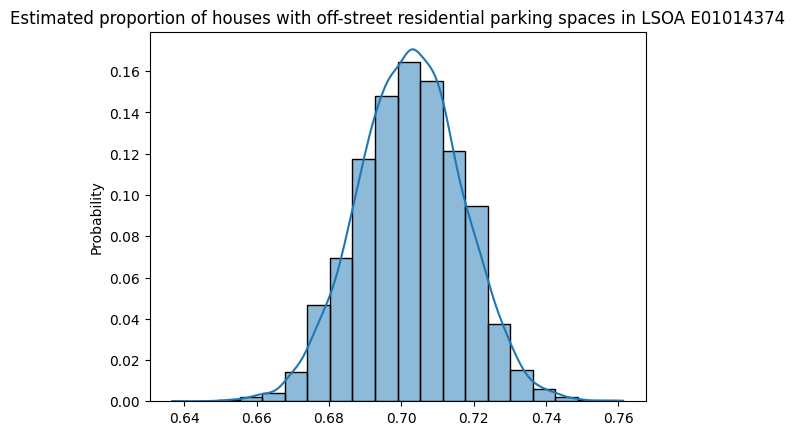

In [178]:
p_on_plot_parking = n_on_plot_parking/house_lsoa.loc[target_lsoa, 'N_households']

sns.histplot(p_on_plot_parking, bins=20, kde=True, stat='probability')
plt.title('Estimated proportion of houses with off-street residential parking spaces in LSOA {}'.format(target_lsoa))

The following tries to account for uncertainty in the English Housing Survey itself. 

However, it's difficult to justify a choice for a prior for the variance of the beta distribution that is assumed to describe the statsitics.

Until, the variance can be justified, this approach will be excluded from the analysis.

In [179]:
# n_on_plot_parking = np.empty(shape=[1000, 100])

# for i in range(0, 1000):

#     # Uncertainty in the English Housing Survey Statistics. 
#     # Assume that these statistics are distributed according to a beta distribution 
#     # The variance is arbitraty at the moment.

#     mu = on_plot_parking_availability_series.values
#     var = 0.05 * mu*(1-mu)

#     alpha = mu*(mu*(1-mu)/var - 1)
#     beta = (1-mu)*(mu*(1-mu)/var - 1)

#     # Assume a binomial distribution describes the spread of the likely numbers of houses of a given accommodation type with on-plot parking.

#     n = np.sum(
#         binom.rvs(
#             n=[accommodation_type_lsoa.loc[target_lsoa].loc[x].astype(int) for x in on_plot_parking_availability_series.index.values], 
#             p=stats.beta.rvs(a=alpha, b=beta).tolist(),
#             size=(100, 5)
#         ),
#         axis=1
#     )

#     n_on_plot_parking [i] = n

# n_on_plot_parking  = n_on_plot_parking .flatten()

# sns.histplot(n_on_plot_parking , kde=True, bins=50, alpha=0.3)
# plt.title('Estimated number of households with on-plot residential parking spaces in LSOA {}'.format(target_lsoa))

### Allocating Vehicles to on-plot parking spaces

In [180]:
def calculate_n_vehicles_with_on_plot_parking(target_lsoa, n_on_plot_parking):
    target_lsoa_raw_census_cars_2021 = raw_census_cars_and_vans_2021_df[raw_census_cars_and_vans_2021_df['Lower Layer Super Output Areas Code'] == target_lsoa]

    if target_lsoa in census_cars_and_vans_2021_df.index:
        number_of_cars = census_cars_and_vans_2021_df.loc[target_lsoa, 'number_of_cars']
        number_of_houses = house_lsoa.loc[target_lsoa, 'N_households']
        number_of_houses_with_cars = target_lsoa_raw_census_cars_2021[target_lsoa_raw_census_cars_2021['Car or van availability (5 categories) Code'] == 0].Observation.iloc[0]

    # If the LSOA doesn't show up in the 2021 census, use the 2011 census
    else:
        number_of_cars = census_cars_and_vans_2011_df.loc[target_lsoa, 'number_of_cars']
        number_of_houses = census_number_of_households_2011.loc[target_lsoa]
        number_of_houses_with_cars = census_households_with_no_cars_2011.loc[target_lsoa]

    # Mean cars per household (of houses that own at least 1 car)
    if_car_how_many = number_of_cars / (number_of_houses - number_of_houses_with_cars)

    # Number of households with access to at least 1 car.
    # (Estimated number of vehicles divided by the mean car-to-car-owning-household ratio)

    households_with_car = registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations) / if_car_how_many

    return np.clip(np.random.choice(households_with_car, size=len(n_on_plot_parking)), a_min=0, a_max=n_on_plot_parking) * if_car_how_many

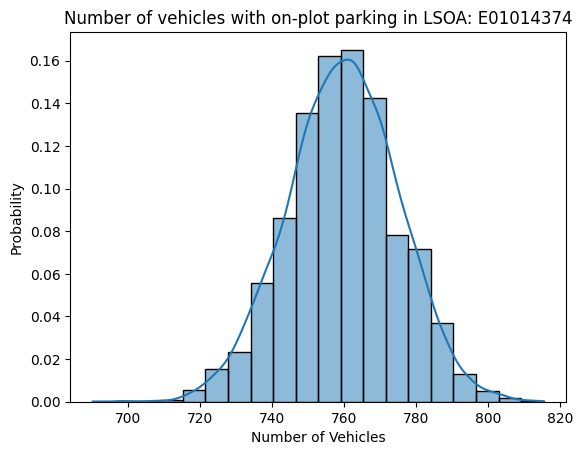

In [181]:
n_vehicles_with_on_plot_parking = calculate_n_vehicles_with_on_plot_parking(target_lsoa, calculate_n_on_plot_parking(target_lsoa, n_samples))

# Number of cars with on-plot parking access
sns.histplot(
    n_vehicles_with_on_plot_parking,
    bins=20,
    kde=True,
    stat='probability'
)
plt.xlabel('Number of Vehicles')
plt.title('Number of vehicles with on-plot parking in LSOA: {}'.format(target_lsoa))
plt.show()

### Allocating EVs to on-plot parking spaces

Currently, with the low levels of public charging infrastructure, prospective car buyers will be more likely to purchace an EV if they have on-plot parking access, thus guaranteeing them a charging point.

In [182]:
# Calculate the proportion of EVs with on-plot parking access
def calculate_p_evs_with_on_plot_parking(p_cars_on_plot_parking, alpha, beta, mean_vehicles, n_evs):
    c = stats.beta.rvs(a=alpha, b=beta, size=n_samples) # y intercept
    m = (p_cars_on_plot_parking - c)/mean_vehicles # gradient
    p = m*n_evs + c
    return np.clip(p, a_min=0, a_max=1)

In [183]:
# For a given number of vehicles with on-plot parking, calculate the number of EVs also with on-plot parking access.
def calculate_n_evs_with_on_plot_parking(n_vehicles_with_on_plot_parking, census_cars, mean_vehicles, n_evs):
    # Proportion of cars with on-plot parking
    p_cars_on_plot_parking = np.clip(n_vehicles_with_on_plot_parking/census_cars, a_min=0, a_max=1)

    # Define alpha and beta values for beta distribution that describes likely starting points for EV on-plot parking access
    mu = 0.9 # prior mean
    var = 0.1 * mu*(1-mu)

    alpha = mu*(mu*(1-mu)/var - 1)
    beta = (1-mu)*(mu*(1-mu)/var - 1)

    # Return proportion of EVs with on-plot parking access. 
    # This changes depending on how many EVs there are relative to the total number of vehicles
    # It approaches the overall proportion for all vehicles.
    p_evs_with_on_plot_parking = calculate_p_evs_with_on_plot_parking(p_cars_on_plot_parking, alpha, beta, mean_vehicles, n_evs)

    n_evs_with_on_plot_parking = (p_evs_with_on_plot_parking * n_evs).round(0)
    
    return n_evs_with_on_plot_parking 

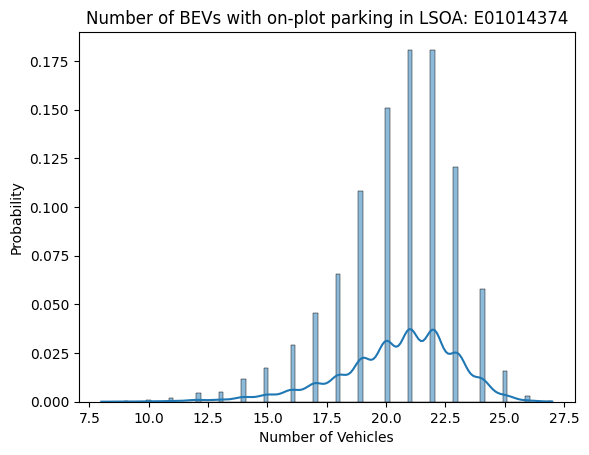

In [184]:
n_bevs_with_on_plot_parking = calculate_n_evs_with_on_plot_parking(
    n_vehicles_with_on_plot_parking = calculate_n_vehicles_with_on_plot_parking(target_lsoa, calculate_n_on_plot_parking(target_lsoa, n_samples)), 
    census_cars = census_cars_and_vans_2021_df.loc[target_lsoa, 'number_of_cars'], 
    mean_vehicles = (registered_vehicles_lsoa.loc[target_lsoa, '2023 Q1'] * (1 + simulated_observations)).mean(), 
    n_evs = np.random.choice(
        (bev_lsoa_i.loc['2023 Q1', target_lsoa] * (1 + simulated_observations)).round(0), 
        size=n_samples
    )
)

# Number of BEVs with access to on-plot parking
sns.histplot(
    n_bevs_with_on_plot_parking,
    bins=100,
    kde=True,
    stat='probability'
)

plt.xlabel('Number of Vehicles')
plt.title('Number of BEVs with on-plot parking in LSOA: {}'.format(target_lsoa))
plt.show()

The function below produces estimates for a range of LSOAs.

In [185]:
def estimate_evs_with_on_plot_parking_multiple_lsoas(target_lsoas, ev_data):
    
    est_vehicles_with_on_plot_parking = {}
    for lsoa in target_lsoas:
        alpha = trace.posterior.sel(LSOA=lsoa).alpha.stack(combined=('chain', 'draw')).to_numpy()
        sigma_y = trace.posterior.sel(LSOA=lsoa).sigma_y.stack(combined=('chain', 'draw')).to_numpy()
        simulated_observations = alpha + np.random.normal(0, sigma_y)

        # if the LSOA isn't present in the 2021 census, use the 2011 census
        if lsoa in census_cars_and_vans_2021_df.index:
            census_cars = census_cars_and_vans_2021_df.loc[lsoa, 'number_of_cars']
        else:
            census_cars = census_cars_and_vans_2011_df.loc[lsoa, 'number_of_cars']

        n_evs_with_on_plot_parking = calculate_n_evs_with_on_plot_parking(
            n_vehicles_with_on_plot_parking = calculate_n_vehicles_with_on_plot_parking(lsoa, calculate_n_on_plot_parking(lsoa, n_samples)), 
            census_cars = census_cars, 
            mean_vehicles = (registered_vehicles_lsoa.loc[lsoa, '2023 Q1'] * (1 + simulated_observations)).mean(), 
            n_evs = np.random.choice(
                (ev_data.loc['2023 Q1', lsoa] * (1 + simulated_observations)).round(0), 
                size=n_samples
            )
        )

        est_vehicles_with_on_plot_parking[lsoa] = (n_evs_with_on_plot_parking).round(0)

    est_vehicles_with_on_plot_parking_df = pd.DataFrame(est_vehicles_with_on_plot_parking)

    return est_vehicles_with_on_plot_parking_df

In [186]:
est_bevs_with_on_plot_parking_df = estimate_evs_with_on_plot_parking_multiple_lsoas(bev_lsoa.index.values.tolist(), bev_lsoa_i)
est_bevs_with_on_plot_parking_df.head()

,E01014370,E01014371,E01014372,E01014373,E01014374,E01014375,E01014376,E01014377,E01014379,E01014380,...,E01033079,E01033080,E01014431,E01014435,E01014458,E01014461,E01014462,E01014463,E01014473,E01014474
0,11.0,9.0,7.0,13.0,20.0,31.0,15.0,26.0,14.0,32.0,...,15.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.0,10.0,9.0,15.0,21.0,28.0,18.0,19.0,14.0,38.0,...,11.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.0,9.0,10.0,14.0,21.0,30.0,21.0,13.0,17.0,34.0,...,15.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.0,7.0,11.0,12.0,24.0,30.0,21.0,24.0,16.0,37.0,...,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.0,6.0,9.0,13.0,19.0,28.0,13.0,19.0,16.0,28.0,...,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
est_phevs_with_on_plot_parking_df = estimate_evs_with_on_plot_parking_multiple_lsoas(phev_lsoa.index.values.tolist(), phev_lsoa_i)
est_phevs_with_on_plot_parking_df.head()

,E01014370,E01014371,E01014372,E01014373,E01014374,E01014375,E01014376,E01014377,E01014379,E01014380,...,E01033079,E01033080,E01014431,E01014435,E01014458,E01014461,E01014462,E01014463,E01014473,E01014474
0,0.0,6.0,6.0,0.0,14.0,20.0,13.0,13.0,19.0,24.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,7.0,7.0,0.0,9.0,23.0,14.0,11.0,20.0,20.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,6.0,7.0,0.0,11.0,18.0,15.0,12.0,21.0,22.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,6.0,7.0,0.0,11.0,18.0,13.0,11.0,17.0,24.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,6.0,8.0,0.0,12.0,20.0,10.0,12.0,17.0,24.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Mapping data from LSOAs to distribution substations

### Load distribution substation data

In [64]:
ds = (
    pd.read_csv('../../data/network_data/distribution_substations.csv')
    .drop(
        columns = [
            'Transformer Headroom', 'LCT Count Total', 'Energy Storage', 'Heat Pumps', 
            'EV Chargers', 'Total LCT Capacity', 'Total Generation Capacity', 'Solar', 
            'Wind', 'Bio Fuels', 'Water Generation', 'Waste Generation',
            'Storage Generation', 'Fossil Fuels', 'Other Generation']
    )
    .replace('Hidden', np.nan)
    .astype({'Customers':'float64', 'Substation Number':'Int64'})
    .astype({'Substation Number': str})
)
ds.head()

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_47261/1009921689.py:2: DtypeWarning: Columns (19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('../../data/network_data/distribution_substations.csv')


,index,License Area,Grid Supply Point Number,Grid Supply Point Name,Bulk Supply Point Number,Bulk Supply Point Name,Primary Name,Primary Number,HV Feeder,Substation Type,Substation Name,Substation Number,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,Customers
0,0,South West,306004,Abham S.G.P.,330006,Plympton Bsp,Linketty Lane,330029,330029/0016,Grd Mtd,Burniston Close 47,331299,SX553570552680,-4.035800,50.379400,189.0,78.0,500.0,115.0
1,1,South West,306004,Abham S.G.P.,330003,Plymouth Bsp,Plymstock South,330037,330037/0017,Grd Mtd,Furland Close,332445,SX504350522380,-4.103733,50.350925,88.0,46.0,1000.0,59.0
2,2,South West,306004,Abham S.G.P.,330003,Plymouth Bsp,Plymstock South,330037,330037/0018,Grd Mtd,Staddon Park,331216,SX513550525160,-4.090900,50.353700,184.0,106.0,500.0,149.0
3,4,South West,306004,Abham S.G.P.,330006,Plympton Bsp,Linketty Lane,330029,330029/0016,Grd Mtd,St Maurice Road,331196,SX548280554220,-4.043300,50.380700,286.0,121.0,500.0,178.0
4,5,South West,406003,Landulph S.G.P.,330001,Ernesettle Bsp,Southway,330023,330023/0046,Grd Mtd,Birch Valley Plastic,333252,SX513960603110,-4.093400,50.423700,746.0,453.0,1000.0,27.0


In [65]:
ds_geo = (
    gpd.read_file('../../data/network_data/dist_swest_march2023.gpkg')
    .rename(columns={'NR':'Substation Number'})
    .dissolve('Substation Number').reset_index()
    .merge(ds, how='left', on ='Substation Number')
    .rename(columns={'Substation Name':'Name'})
    .fillna(value={'Discount':'Unknown'}) # For the "key_on" part of the choropleth map
    .to_crs('EPSG:4326')
)

ds_geo['Location'] = gpd.GeoSeries(gpd.points_from_xy(ds_geo.LONGITUDE, ds_geo.LATITUDE, crs="EPSG:4326"))

ds_geo.head()

,Substation Number,geometry,NRID,NR_TYPE_ID,NAME,PRIM_NRID,PRIM_NRID_NAME,BSP_NRID,BSP_NRID_NAME,GSP_NRID,...,Substation Type,Name,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,Customers,Location
0,110001,"MULTIPOLYGON (((-2.58570 51.47167, -2.58578 51...",33447,19,Chesterfield Rd Id,15039,St Pauls Bsp 11kv,104,St Pauls Bsp 132kv,130,...,Grd Mtd,Chesterfield Rd Id,ST596270749730,-2.5827,51.4722,568.0,343.0,750.0,367.0,POINT (-2.58270 51.47220)
1,110002,"MULTIPOLYGON (((-2.59002 51.47053, -2.59028 51...",33449,19,Effingham Road Id,15039,St Pauls Bsp 11kv,104,St Pauls Bsp 132kv,130,...,Grd Mtd,Effingham Road Id,ST591950749860,-2.5889,51.4723,458.0,275.0,750.0,331.0,POINT (-2.58890 51.47230)
2,110003,"POLYGON ((-2.59156 51.47416, -2.59154 51.47425...",33451,19,Somerville Rd,15039,St Pauls Bsp 11kv,104,St Pauls Bsp 132kv,130,...,Grd Mtd,Somerville Rd,ST590740753250,-2.5907,51.4753,10.0,4.0,250.0,254.0,POINT (-2.59070 51.47530)
3,110003,"POLYGON ((-2.59156 51.47416, -2.59154 51.47425...",33451,19,Somerville Rd,15039,St Pauls Bsp 11kv,104,St Pauls Bsp 132kv,130,...,Grd Mtd,Somerville Rd,ST590740753250,-2.5907,51.4753,0.0,0.0,500.0,NaN,POINT (-2.59070 51.47530)
4,110004,"MULTIPOLYGON (((-2.58898 51.47610, -2.58895 51...",33453,19,Kent Road P,15039,St Pauls Bsp 11kv,104,St Pauls Bsp 132kv,130,...,Grd Mtd,Kent Road P,ST593560755280,-2.5867,51.4772,607.0,320.0,750.0,276.0,POINT (-2.58670 51.47720)


### Load LSOA Geo data

In [66]:
lsoa_geo = (
    gpd.read_file('../../data/spatial_data/lsoa_data/Lower_Layer_Super_Output_Areas__December_2011__Boundaries_Full_Clipped__BFC__EW_V3.shp')
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on = 'LSOA11CD', how='outer')
    .set_index('LSOA11CD')
) 
lsoa_geo.head()

,OBJECTID,LSOA11NM,BNG_E,BNG_N,LONG_,LAT,Shape_Leng,Shape__Are,Shape__Len,geometry,LAD22NM
LSOA11CD,,,,,,,,,,,
E01000001,1,City of London 001A,532123,181632,-0.097140,51.5182,2635.767993,129865.314354,2635.767993,"POLYGON ((532151.537 181867.433, 532152.500 18...",City of London
E01000002,2,City of London 001B,532480,181715,-0.091970,51.5188,2707.881853,228419.634727,2707.881853,"POLYGON ((532634.497 181926.016, 532632.048 18...",City of London
E01000003,3,City of London 001C,532239,182033,-0.095320,51.5217,1224.638192,59054.351929,1224.638192,"POLYGON ((532153.703 182165.155, 532158.250 18...",City of London
E01000005,4,City of London 001E,533581,181283,-0.076270,51.5147,2275.805348,189577.710655,2275.805348,"POLYGON ((533619.062 181402.364, 533639.868 18...",City of London
E01000006,5,Barking and Dagenham 016A,544994,184274,0.089317,51.5387,1966.092607,146536.995750,1966.092607,"POLYGON ((545126.852 184310.838, 545145.213 18...",Barking and Dagenham


### Load lad Boundary with osmnx

In [67]:
def return_lad_geo(lad):
    return ox.geocoder.geocode_to_gdf(lad, which_result=1)

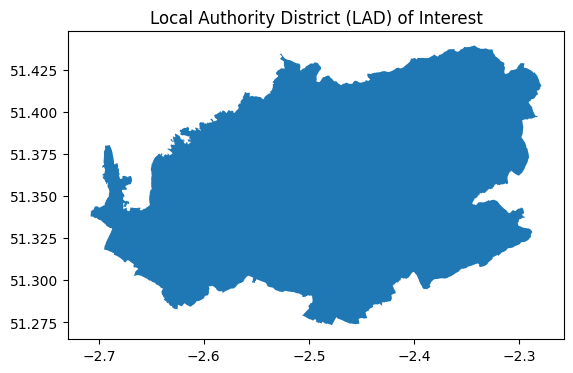

In [68]:
return_lad_geo(lad).plot()
plt.title('Local Authority District (LAD) of Interest')
plt.show()

### Filter LSOAs by lad

In [69]:
def filter_lsoas_by_lad(lsoa_geo, lad):
    lsoa_lad = lsoa_geo.loc[lambda x: x['LAD22NM'] == lad].to_crs('EPSG:4326') # Filter for LA and change CRS
    lsoa_lad = lsoa_lad.drop_duplicates()
    return lsoa_lad

In [70]:
lsoa_lad = filter_lsoas_by_lad(lsoa_geo, lad)
lsoa_lad.head()

,OBJECTID,LSOA11NM,BNG_E,BNG_N,LONG_,LAT,Shape_Leng,Shape__Are,Shape__Len,geometry,LAD22NM
LSOA11CD,,,,,,,,,,,
E01014370,13973,Bath and North East Somerset 007A,375084,164994,-2.35941,51.3834,4168.323516,3.770303e+05,4168.323516,"POLYGON ((-2.35647 51.38920, -2.35618 51.38913...",Bath and North East Somerset
E01014371,13974,Bath and North East Somerset 007B,375328,164841,-2.35590,51.3821,4146.079795,4.094906e+05,4146.079795,"POLYGON ((-2.35166 51.38534, -2.35158 51.38530...",Bath and North East Somerset
E01014372,13975,Bath and North East Somerset 007C,374832,165378,-2.36306,51.3869,2870.144109,1.668015e+05,2870.144109,"POLYGON ((-2.35597 51.38950, -2.35587 51.38942...",Bath and North East Somerset
E01014373,13976,Bath and North East Somerset 010A,377791,167691,-2.32068,51.4078,6720.118267,1.059979e+06,6720.118267,"POLYGON ((-2.32115 51.41364, -2.32114 51.41364...",Bath and North East Somerset
E01014374,13977,Bath and North East Somerset 010B,378059,166769,-2.31677,51.3995,19927.251976,5.002127e+06,19927.251976,"POLYGON ((-2.30592 51.40806, -2.30591 51.40806...",Bath and North East Somerset


### Filter distribution substations by lad

In [71]:
def filter_ds_by_lad(ds_geo, lad_geo):
    return ds_geo.loc[ds_geo.Location.within(lad_geo.geometry.values[0])]

In [72]:
lad_geo = return_lad_geo(lad)
ds_lad = filter_ds_by_lad(ds_geo, lad_geo)
ds_lad.head()

,Substation Number,geometry,NRID,NR_TYPE_ID,NAME,PRIM_NRID,PRIM_NRID_NAME,BSP_NRID,BSP_NRID_NAME,GSP_NRID,...,Substation Type,Name,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,Customers,Location
37,110055,"POLYGON ((-2.46167 51.39973, -2.46174 51.39976...",33528,19,Saltford Od,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Grd Mtd,Saltford Od,ST682140670940,-2.45840,51.401900,339.0,228.0,500.0,129.0,POINT (-2.45840 51.40190)
39,110060,"POLYGON ((-2.49497 51.40702, -2.49581 51.40727...",33532,19,Keelings Ss,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Grd Mtd,Keelings Ss,ST658270679910,-2.49280,51.409800,204.0,90.0,315.0,114.0,POINT (-2.49280 51.40980)
44,110066,"POLYGON ((-2.49769 51.40349, -2.49779 51.40351...",33542,19,Burnett Rd K,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Grd Mtd,Burnett Rd K,ST658460673840,-2.49242,51.404389,157.0,70.0,300.0,95.0,POINT (-2.49242 51.40439)
107,110165,"POLYGON ((-2.51360 51.41669, -2.51393 51.41716...",33683,19,Stockwood Vale Od,15049,Keynsham West,128239,Feeder Road 33kv,130,...,Grd Mtd,Stockwood Vale Od,ST644800689440,-2.51220,51.418300,102.0,49.0,500.0,47.0,POINT (-2.51220 51.41830)
123,110182,"POLYGON ((-2.46675 51.40341, -2.46675 51.40341...",33715,19,Grange Road K,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Grd Mtd,Grange Road K Saltford,ST677120673570,-2.46560,51.404300,104.0,50.0,315.0,54.0,POINT (-2.46560 51.40430)


In [73]:
len(ds_lad)

1761

### Identify target substation

In [74]:
target_ds = random.choice(ds_lad['Substation Number'].values) # '110055' '160038'
# target_ds = '160038'
target_ds

'164195'

### Find parent LSOA(s)

In [75]:
def find_parent_lsoas(target_ds, ds_lad, lsoa_lad):
    intersections = lsoa_lad.geometry.intersection(ds_lad[ds_lad['Substation Number'] == target_ds].geometry.values[0])
    pip_mask = ~intersections.is_empty
    parent_lsoas = lsoa_lad[pip_mask].index.values
    return parent_lsoas, intersections

In [76]:
find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0]

array(['E01014371'], dtype=object)

In [77]:
lsoa_lad.loc[find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0]]

,OBJECTID,LSOA11NM,BNG_E,BNG_N,LONG_,LAT,Shape_Leng,Shape__Are,Shape__Len,geometry,LAD22NM
LSOA11CD,,,,,,,,,,,
E01014371,13974,Bath and North East Somerset 007B,375328,164841,-2.3559,51.3821,4146.079795,409490.633312,4146.079795,"POLYGON ((-2.35166 51.38534, -2.35158 51.38530...",Bath and North East Somerset


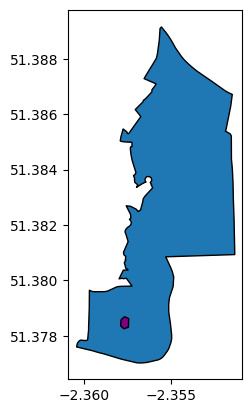

In [78]:
fig, ax = plt.subplots()
lsoa_lad.loc[find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0]].plot(ax=ax, edgecolor='k')
find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1].loc[find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0]].plot(ax=ax, color='purple', edgecolor='k')
plt.show()

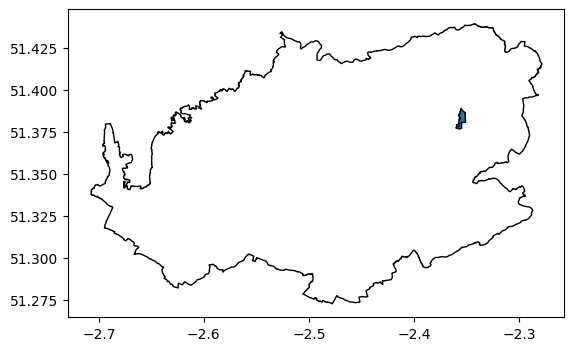

In [79]:
fig, ax = plt.subplots()
lad_geo.plot(ax=ax, color='white', edgecolor='k')
lsoa_lad.loc[find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0]].plot(ax=ax, edgecolor='k')
find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1].loc[find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0]].plot(ax=ax, color='purple', edgecolor='k')
plt.show()

### Calculate the proportion of Distribution Substation Area that overlaps with the Parent LSOAs

In [80]:
def calculate_relative_intersection(target_ds, ds_lad, parent_lsoas, intersections):
    return intersections.loc[parent_lsoas].area / ds_lad[ds_lad['Substation Number'] == target_ds].iloc[0].geometry.area

In [81]:
calculate_relative_intersection(target_ds, ds_lad, find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1])

LSOA11CD
E01014371    1.0
dtype: float64

### Number of households (customers) in each of the parent LSOAs

In [82]:
house_lsoa.loc[find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0]].N_households

LSOA11CD
E01014371    1044
Name: N_households, dtype: int64

### Total number of customers connected to the distribution substation.

In [83]:
len(ds_lad.Customers)

1761

<Axes: ylabel='Frequency'>

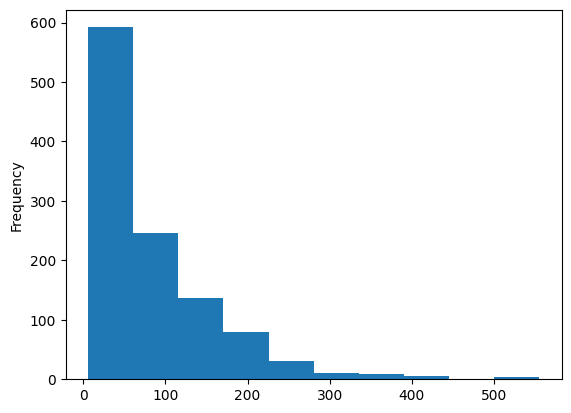

In [84]:
ds_lad.Customers.plot.hist()

In [85]:
sum(ds_lad.Customers.isna())

649

In [86]:
ds_lad[ds_lad['Substation Number'] == target_ds]

,Substation Number,geometry,NRID,NR_TYPE_ID,NAME,PRIM_NRID,PRIM_NRID_NAME,BSP_NRID,BSP_NRID_NAME,GSP_NRID,...,Substation Type,Name,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,Customers,Location
5894,164195,"POLYGON ((-2.35791 51.37837, -2.35789 51.37860...",306405,19,"Debenhams ""B""",302497,Dorchester St - New,94,Bath (Dolemeads) 132,131,...,Grd Mtd,"Debenhams ""B""",ST752160644480,-2.3575,51.3785,0.0,0.0,800.0,NaN,POINT (-2.35750 51.37850)


In [87]:
def return_ds_customers(target_ds, ds_lad):
    ds_customers = ds_lad[ds_lad['Substation Number'] == target_ds].iloc[0].Customers
    if math.isnan(ds_customers):
        ds_customers = 0
    return ds_customers

In [88]:
return_ds_customers(target_ds, ds_lad)

0

### Approximate number of distribution substation customers that are located in each parent LSOA.

In [89]:
def calculate_ds_customers_in_lsoas(target_ds, ds_lad, parent_lsoas, intersections):
    relative_intersection = calculate_relative_intersection(target_ds, ds_lad, parent_lsoas, intersections)
    ds_customers = return_ds_customers(target_ds, ds_lad)
    return relative_intersection * ds_customers

In [90]:
calculate_ds_customers_in_lsoas(target_ds, ds_lad, find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1])

LSOA11CD
E01014371    0.0
dtype: float64

### Approximate number of households in each parent LSOA that are connected to the target distribution substation.

In [91]:
def calculate_household_intersection(target_ds, ds_lad, parent_lsoas, intersections, house_lsoa):
    ds_customers_in_lsoas = calculate_ds_customers_in_lsoas(target_ds, ds_lad, parent_lsoas, intersections)
    N_households_lsoa = house_lsoa.loc[parent_lsoas].N_households
    return ds_customers_in_lsoas.divide(N_households_lsoa)

In [92]:
calculate_household_intersection(target_ds, ds_lad, find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1], house_lsoa)

LSOA11CD
E01014371    0.0
dtype: float64

### Allocate Vehicles from LSOAs to DS

In [93]:
lsoa_lad.loc[find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0]].index

Index(['E01014371'], dtype='object', name='LSOA11CD')

In [94]:
estimate_vehicles_multiple_lsoas(registered_vehicles_lsoa.index.values.tolist())[lsoa_lad.loc[find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0]].index]

,E01014371
0,686.0
1,642.0
2,641.0
3,693.0
4,629.0
...,...
7995,742.0
7996,698.0
7997,674.0
7998,653.0


In [95]:
estimate_vehicles_multiple_lsoas(registered_vehicles_lsoa.index.values.tolist())

,E01014370,E01014371,E01014372,E01014373,E01014374,E01014375,E01014376,E01014377,E01014379,E01014380,...,E01014478,E01014479,E01014480,E01014481,E01014482,E01014483,E01014484,E01033078,E01033079,E01033080
0,455.0,688.0,666.0,948.0,910.0,1022.0,1078.0,970.0,1433.0,995.0,...,451.0,774.0,616.0,542.0,641.0,533.0,632.0,1205.0,905.0,788.0
1,461.0,668.0,637.0,936.0,848.0,911.0,1041.0,879.0,1390.0,752.0,...,508.0,735.0,602.0,534.0,676.0,485.0,661.0,1107.0,887.0,825.0
2,464.0,683.0,682.0,901.0,782.0,862.0,961.0,832.0,1590.0,796.0,...,523.0,832.0,576.0,555.0,771.0,554.0,648.0,1142.0,907.0,845.0
3,431.0,673.0,690.0,866.0,870.0,993.0,1002.0,981.0,1688.0,873.0,...,464.0,726.0,663.0,553.0,681.0,549.0,649.0,1040.0,835.0,784.0
4,454.0,674.0,657.0,899.0,952.0,873.0,1135.0,847.0,1444.0,798.0,...,564.0,783.0,600.0,461.0,618.0,486.0,662.0,1122.0,840.0,786.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,452.0,631.0,624.0,947.0,925.0,813.0,1213.0,904.0,1514.0,798.0,...,472.0,809.0,639.0,498.0,700.0,502.0,586.0,1252.0,872.0,775.0
7996,449.0,730.0,663.0,884.0,928.0,958.0,1090.0,929.0,1646.0,817.0,...,521.0,713.0,638.0,543.0,721.0,543.0,591.0,1174.0,776.0,770.0
7997,448.0,698.0,687.0,904.0,932.0,994.0,1042.0,775.0,1527.0,848.0,...,606.0,804.0,611.0,542.0,665.0,512.0,687.0,1243.0,829.0,814.0
7998,486.0,616.0,621.0,887.0,950.0,941.0,1017.0,885.0,1506.0,896.0,...,496.0,672.0,687.0,461.0,584.0,544.0,646.0,1269.0,901.0,797.0


In [96]:
def allocate_vehicles_from_lsoa_to_ds(estimate_vehicles_multiple_lsoas, lsoa_lad, target_ds, ds_lad, house_lsoa, parent_lsoas, intersections):

    est_vehicles_target_lsoas = estimate_vehicles_multiple_lsoas[lsoa_lad.loc[parent_lsoas].index]
    household_intersection = calculate_household_intersection(target_ds, ds_lad, parent_lsoas, intersections, house_lsoa)

    n_vehicles_from_lsoas = []
    for lsoa in parent_lsoas: # For each intersecting LSOA
        n_vehicles_from_lsoas.append(binom.rvs(n=est_vehicles_target_lsoas[lsoa].astype(int), p=household_intersection.loc[lsoa], size=(1, 8000)))

    n_vehicles_from_lsoas = np.add.reduce(n_vehicles_from_lsoas).flatten()

    return n_vehicles_from_lsoas

In [97]:
allocate_vehicles_from_lsoa_to_ds(
    estimate_vehicles_multiple_lsoas(registered_vehicles_lsoa.index.values.tolist()), 
    lsoa_lad, 
    target_ds, 
    ds_lad, 
    house_lsoa, 
    find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], 
    find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1]
)

array([0, 0, 0, ..., 0, 0, 0])

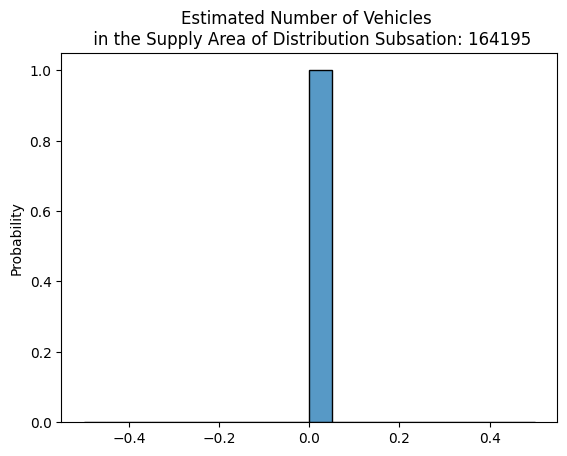

In [98]:
sns.histplot(
    allocate_vehicles_from_lsoa_to_ds(
        estimate_vehicles_multiple_lsoas(registered_vehicles_lsoa.index.values.tolist()), 
        lsoa_lad, 
        target_ds, 
        ds_lad, 
        house_lsoa, 
        find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], 
        find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1]
    ), 
    stat='probability', 
    bins=20
)
plt.title('Estimated Number of Vehicles \n in the Supply Area of Distribution Subsation: {}'.format(target_ds))
plt.show()

### Allocate BEVs from LSOAs to DS

In [99]:
def allocate_evs_from_lsoa_to_ds(estimate_evs_multiple_lsoas, lsoa_lad, target_ds, ds_lad, house_lsoa, parent_lsoas, intersections):

    est_evs_target_lsoas = estimate_evs_multiple_lsoas[lsoa_lad.loc[parent_lsoas].index]
    household_intersection = calculate_household_intersection(target_ds, ds_lad, parent_lsoas, intersections, house_lsoa)

    n_vehicles_from_lsoas = []
    for lsoa in parent_lsoas: # For each intersecting LSOA
        n_vehicles_from_lsoas.append(binom.rvs(n=est_evs_target_lsoas[lsoa].astype(int), p=household_intersection.loc[lsoa], size=(1, 8000)))

    n_vehicles_from_lsoas = np.add.reduce(n_vehicles_from_lsoas).flatten()

    return n_vehicles_from_lsoas

In [100]:
allocate_evs_from_lsoa_to_ds(
    estimate_evs_multiple_lsoas(bev_lsoa.index.values.tolist(), bev_lsoa_i), 
    lsoa_lad, 
    target_ds, 
    ds_lad, 
    house_lsoa, 
    find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], 
    find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1]
)

array([0, 0, 0, ..., 0, 0, 0])

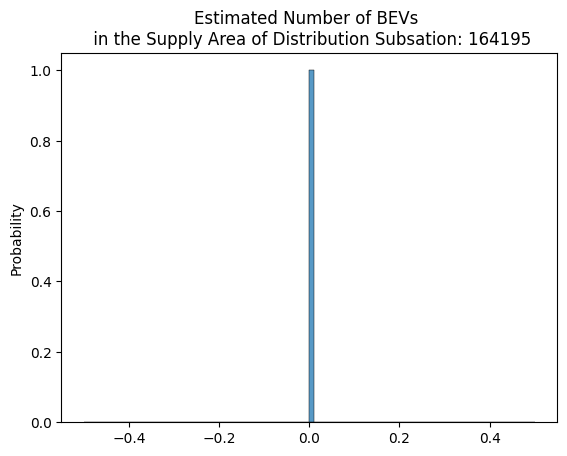

In [101]:
sns.histplot(
    allocate_evs_from_lsoa_to_ds(
        estimate_evs_multiple_lsoas(bev_lsoa.index.values.tolist(), bev_lsoa_i), 
        lsoa_lad, 
        target_ds, 
        ds_lad, 
        house_lsoa, 
        find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], 
        find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1]
    ), 
    stat='probability', 
    bins=100
)
plt.title('Estimated Number of BEVs \n in the Supply Area of Distribution Subsation: {}'.format(target_ds))
plt.show()

### Allocate BEVs with on-plot parking access from LSOAs to DS

In [102]:
def allocate_evs_with_on_plot_parking_from_lsoa_to_ds(est_evs_with_on_plot_parking_multiple_lsoas, lsoa_lad, target_ds, ds_lad, house_lsoa, parent_lsoas, intersections):
    
    est_evs_with_on_plot_parking_target_lsoas = est_evs_with_on_plot_parking_multiple_lsoas[lsoa_lad.loc[parent_lsoas].index]

    household_intersection = calculate_household_intersection(target_ds, ds_lad, parent_lsoas, intersections, house_lsoa)

    n_evs_with_on_plot_parking_from_lsoas = []
    for lsoa in parent_lsoas: # For each intersecting LSOA
        n_evs_with_on_plot_parking_from_lsoas.append(binom.rvs(n=est_evs_with_on_plot_parking_target_lsoas[lsoa].astype(int), p=household_intersection.loc[lsoa], size=(1, n_samples)))

    n_evs_with_on_plot_parking_from_lsoas = np.add.reduce(n_evs_with_on_plot_parking_from_lsoas).flatten()

    return n_evs_with_on_plot_parking_from_lsoas

In [103]:
allocate_evs_with_on_plot_parking_from_lsoa_to_ds(
    estimate_evs_with_on_plot_parking_multiple_lsoas(bev_lsoa.index.values.tolist(), bev_lsoa_i), 
    lsoa_lad, 
    target_ds, 
    ds_lad, 
    house_lsoa, 
    find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], 
    find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1]
)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

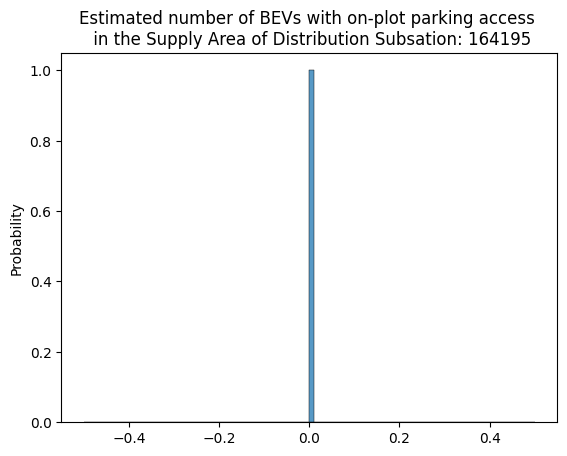

In [104]:
sns.histplot(
    allocate_evs_with_on_plot_parking_from_lsoa_to_ds(
        estimate_evs_with_on_plot_parking_multiple_lsoas(bev_lsoa.index.values.tolist(), bev_lsoa_i), 
        lsoa_lad, 
        target_ds, 
        ds_lad, 
        house_lsoa, 
        find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], 
        find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1]
    ), 
    stat='probability', 
    bins=100
)
plt.title('Estimated number of BEVs with on-plot parking access \n in the Supply Area of Distribution Subsation: {}'.format(target_ds))
plt.show()

### Allocate PHEVs from LSOAs to DS

In [105]:
allocate_evs_from_lsoa_to_ds(
    estimate_evs_multiple_lsoas(phev_lsoa.index.values.tolist(), phev_lsoa_i), 
    lsoa_lad, 
    target_ds, 
    ds_lad, 
    house_lsoa, 
    find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], 
    find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1]
)

array([0, 0, 0, ..., 0, 0, 0])

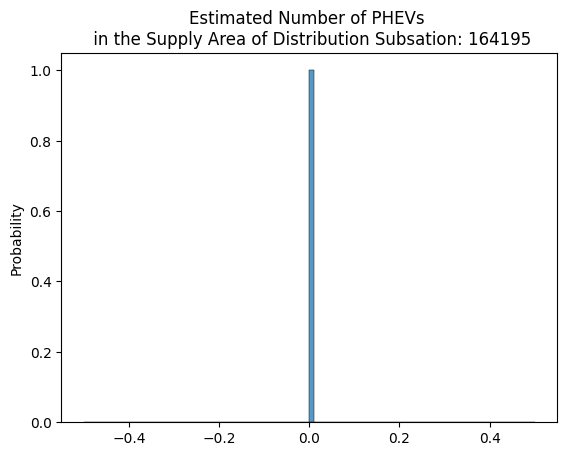

In [106]:
sns.histplot(
    allocate_evs_from_lsoa_to_ds(
        estimate_evs_multiple_lsoas(phev_lsoa.index.values.tolist(), phev_lsoa_i), 
        lsoa_lad, 
        target_ds, 
        ds_lad, 
        house_lsoa, 
        find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], 
        find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1]
    ), 
    stat='probability', 
    bins=100
)
plt.title('Estimated Number of PHEVs \n in the Supply Area of Distribution Subsation: {}'.format(target_ds))
plt.show()

### Allocate PHEVs with on-plot parking from LSOAs to DS

In [107]:
allocate_evs_with_on_plot_parking_from_lsoa_to_ds(
    estimate_evs_with_on_plot_parking_multiple_lsoas(phev_lsoa.index.values.tolist(), phev_lsoa_i), 
    lsoa_lad, 
    target_ds, 
    ds_lad, 
    house_lsoa, 
    find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], 
    find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1]
)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

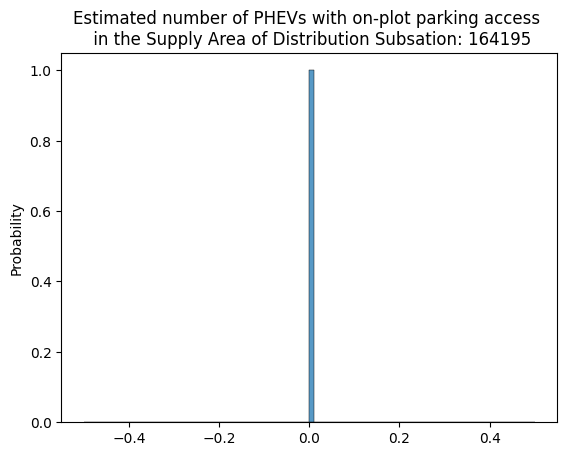

In [108]:
sns.histplot(
    allocate_evs_with_on_plot_parking_from_lsoa_to_ds(
        estimate_evs_with_on_plot_parking_multiple_lsoas(phev_lsoa.index.values.tolist(), phev_lsoa_i), 
        lsoa_lad, 
        target_ds, 
        ds_lad, 
        house_lsoa, 
        find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[0], 
        find_parent_lsoas(target_ds, ds_lad, lsoa_lad)[1]
    ), 
    stat='probability', 
    bins=100
)
plt.title('Estimated number of PHEVs with on-plot parking access \n in the Supply Area of Distribution Subsation: {}'.format(target_ds))
plt.show()

In [109]:
# sns.histplot(
#     stats.truncnorm.rvs(
#         loc=n_phevs_with_on_plot_parking_from_lsoas.mean(), 
#         scale=n_phevs_with_on_plot_parking_from_lsoas.std(), 
#         a=-n_phevs_with_on_plot_parking_from_lsoas.mean()/n_phevs_with_on_plot_parking_from_lsoas.std(), 
#         b=100000, 
#         size=10000
#     ).round(0),
#     bins=100
# )

# Making Estimates for Multiple Distribution Substations

In [173]:
def make_ds_estimates(ds_list, registered_vehicles_lsoa, bev_lsoa, bev_lsoa_i, phev_lsoa, phev_lsoa_i, lsoa_lad, ds_lad, house_lsoa):

    cols = [
        'customers', 
        'vehicles_mean', 
        'vehicles_std', 
        'bevs_mean', 
        'bevs_std', 
        'bevs_with_on_plot_parking_mean', 
        'bevs_with_on_plot_parking_std',
        'phevs_mean', 
        'phevs_std', 
        'phevs_with_on_plot_parking_mean', 
        'phevs_with_on_plot_parking_std'
    ]

    ds_estimates_df = pd.DataFrame(index=ds_list, columns=cols)
    ds_estimates_df.index.name = 'substation_number'

    vehicles_multiple_lsoas = estimate_vehicles_multiple_lsoas(registered_vehicles_lsoa.index.values.tolist())

    bevs_multiple_lsoas = estimate_evs_multiple_lsoas(bev_lsoa.index.values.tolist(), bev_lsoa_i)
    bevs_with_on_plot_parking_multiple_lsoas = estimate_evs_with_on_plot_parking_multiple_lsoas(bev_lsoa.index.values.tolist(), bev_lsoa_i)
    
    phevs_multiple_lsoas = estimate_evs_multiple_lsoas(phev_lsoa.index.values.tolist(), phev_lsoa_i)
    phevs_with_on_plot_parking_multiple_lsoas = estimate_evs_with_on_plot_parking_multiple_lsoas(phev_lsoa.index.values.tolist(), phev_lsoa_i)

    for ds in ds_list:

        ds_estimates_df.loc[ds, 'customers'] = ds_lad[ds_lad['Substation Number'] == ds]['Customers'].values[0]

        parent_lsoas, intersections = find_parent_lsoas(ds, ds_lad, lsoa_lad)

        # All Vehicles

        # vehicles = allocate_vehicles_from_lsoa_to_ds(registered_vehicles_lsoa, lsoa_lad, ds, ds_lad, house_lsoa, parent_lsoas, intersections)

        vehicles = allocate_vehicles_from_lsoa_to_ds(
            vehicles_multiple_lsoas, 
            lsoa_lad, 
            ds, 
            ds_lad, 
            house_lsoa, 
            parent_lsoas, 
            intersections
        )

        ds_estimates_df.loc[ds, 'vehicles_mean'] = vehicles.mean()
        ds_estimates_df.loc[ds, 'vehicles_std'] = vehicles.std()

        # BEVs

        # bevs = allocate_evs_from_lsoa_to_ds(bev_lsoa, bev_lsoa_i, lsoa_lad, ds, ds_lad, house_lsoa, parent_lsoas, intersections)

        bevs = allocate_evs_from_lsoa_to_ds(
            bevs_multiple_lsoas,
            lsoa_lad, 
            ds, 
            ds_lad, 
            house_lsoa, 
            parent_lsoas, 
            intersections
        )

        # bevs_with_on_plot_parking = allocate_evs_with_on_plot_parking_from_lsoa_to_ds(bev_lsoa_i, lsoa_lad, ds, ds_lad, house_lsoa, parent_lsoas, intersections)
        bevs_with_on_plot_parking = allocate_evs_with_on_plot_parking_from_lsoa_to_ds(
            bevs_with_on_plot_parking_multiple_lsoas, 
            lsoa_lad, 
            ds, 
            ds_lad, 
            house_lsoa, 
            parent_lsoas, 
            intersections
        )

        ds_estimates_df.loc[ds, 'bevs_mean'] = bevs.mean()
        ds_estimates_df.loc[ds, 'bevs_std'] = bevs.std()
        ds_estimates_df.loc[ds, 'bevs_with_on_plot_parking_mean'] = bevs_with_on_plot_parking.mean()
        ds_estimates_df.loc[ds, 'bevs_with_on_plot_parking_std'] = bevs_with_on_plot_parking.std()

        # PHEVS

        # phevs = allocate_evs_from_lsoa_to_ds(phev_lsoa, phev_lsoa_i, lsoa_lad, ds, ds_lad, house_lsoa, parent_lsoas, intersections)
        phevs = allocate_evs_from_lsoa_to_ds(
            phevs_multiple_lsoas,
            lsoa_lad, 
            ds, 
            ds_lad, 
            house_lsoa, 
            parent_lsoas, 
            intersections
        )

        # phevs_with_on_plot_parking = allocate_evs_with_on_plot_parking_from_lsoa_to_ds(phev_lsoa_i, lsoa_lad, ds, ds_lad, house_lsoa, parent_lsoas, intersections)
        phevs_with_on_plot_parking = allocate_evs_with_on_plot_parking_from_lsoa_to_ds(
            phevs_with_on_plot_parking_multiple_lsoas, 
            lsoa_lad, 
            ds, 
            ds_lad, 
            house_lsoa, 
            parent_lsoas, 
            intersections
        )

        ds_estimates_df.loc[ds, 'phevs_mean'] = phevs.mean()
        ds_estimates_df.loc[ds, 'phevs_std'] = phevs.std()
        ds_estimates_df.loc[ds, 'phevs_with_on_plot_parking_mean'] = phevs_with_on_plot_parking.mean()
        ds_estimates_df.loc[ds, 'phevs_with_on_plot_parking_std'] = phevs_with_on_plot_parking.std()

    return ds_estimates_df    

In [192]:
ds_list = ds_lad[~ ds_lad.Customers.isna()]['Substation Number'].values

ds_estimates_df = make_ds_estimates(
    ds_list, 
    registered_vehicles_lsoa, 
    bev_lsoa, 
    bev_lsoa_i, 
    phev_lsoa, 
    phev_lsoa_i, 
    lsoa_lad, 
    ds_lad, 
    house_lsoa
)

ds_estimates_df.head()

,customers,vehicles_mean,vehicles_std,bevs_mean,bevs_std,bevs_with_on_plot_parking_mean,bevs_with_on_plot_parking_std,phevs_mean,phevs_std,phevs_with_on_plot_parking_mean,phevs_with_on_plot_parking_std
substation_number,,,,,,,,,,,
110055,129.0,197.435375,16.290736,2.158125,1.364871,1.968,1.304981,2.9125,1.605255,2.6094,1.499544
110060,114.0,161.5105,13.680365,1.961375,1.361666,1.772,1.280865,1.0375,0.986075,0.9416,0.941907
110066,95.0,144.4965,13.164801,1.388875,1.138047,1.28,1.085173,0.7595,0.833762,0.6984,0.80227
110165,47.0,64.76175,8.548142,1.027375,1.006541,0.9276,0.955384,0.36675,0.599995,0.3305,0.568392
110182,54.0,91.993875,10.246443,0.7935,0.869832,0.7138,0.829994,1.116875,1.038492,1.0251,1.004724


In [197]:
ds_estimates_df.sort_values('bevs_mean', ascending=False)

,customers,vehicles_mean,vehicles_std,bevs_mean,bevs_std,bevs_with_on_plot_parking_mean,bevs_with_on_plot_parking_std,phevs_mean,phevs_std,phevs_with_on_plot_parking_mean,phevs_with_on_plot_parking_std
substation_number,,,,,,,,,,,
160091,555.0,576.9545,30.143232,19.39725,3.997555,17.3059,3.975264,13.247875,3.284727,11.8342,3.244428
160038,442.0,422.48675,25.273847,12.54825,2.850118,11.2883,2.842742,7.200875,2.099649,6.4725,2.070276
160145,197.0,274.807625,19.254866,11.2925,3.031781,10.1299,2.993096,7.414,2.461677,6.7001,2.409805
113322,250.0,418.209625,29.547973,11.21925,2.570006,10.0645,2.631148,8.801625,2.300603,7.9802,2.305604
160037,511.0,536.563,28.127314,11.0365,2.542178,9.951,2.569669,11.571,2.437562,10.3598,2.489406
...,...,...,...,...,...,...,...,...,...,...,...
160360,117.0,85.46225,9.472992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164083,145.0,148.934625,13.633574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162562,55.0,79.663125,9.834424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'BEV penetration in BANES Distribution Substations (with known number of customers)')

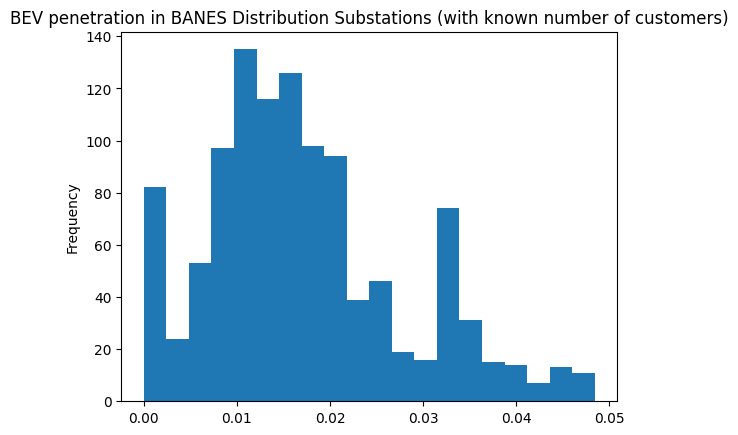

In [216]:
(ds_estimates_df['bevs_mean']/ds_estimates_df['vehicles_mean']).plot.hist(bins=20)
plt.title('BEV penetration in BANES Distribution Substations (with known number of customers)')

Text(0.5, 1.0, 'BEV penetration in BANES Distribution Substations (with known number of customers)')

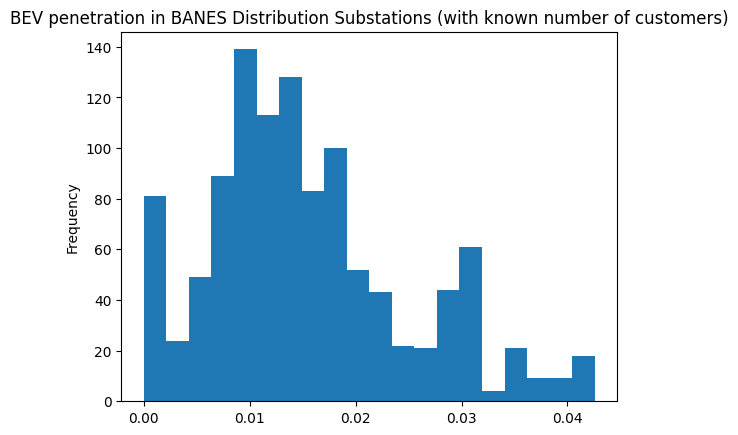

In [213]:
(ds_estimates_df['bevs_with_on_plot_parking_mean']/ds_estimates_df['vehicles_mean']).plot.hist(bins=20)
plt.title('BEV penetration in BANES Distribution Substations (with known number of customers)')

<Axes: ylabel='Frequency'>

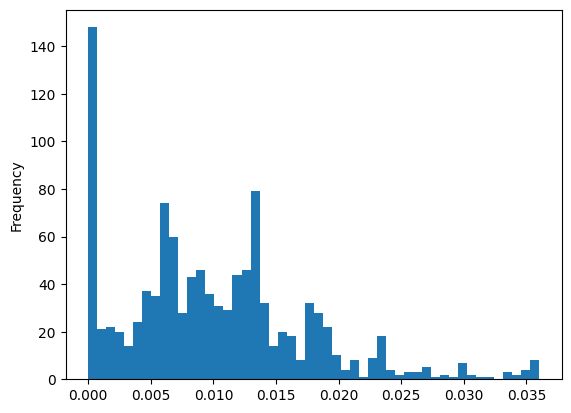

In [210]:
(ds_estimates_df['phevs_mean']/ds_estimates_df['vehicles_mean']).plot.hist(bins=50)

# Mapping Public Chargers to Distribution Substations

In [113]:
import requests
from requests import get

In [114]:
max_results = 200

max_distance = 5 # Units: Km

min_power_kw = 0

In [115]:
ds_lad.geometry

37      POLYGON ((-2.46167 51.39973, -2.46174 51.39976...
39      POLYGON ((-2.49497 51.40702, -2.49581 51.40727...
44      POLYGON ((-2.49769 51.40349, -2.49779 51.40351...
107     POLYGON ((-2.51360 51.41669, -2.51393 51.41716...
123     POLYGON ((-2.46675 51.40341, -2.46675 51.40341...
                              ...                        
8461    POLYGON ((-2.58200 51.36017, -2.58668 51.36013...
8476    POLYGON ((-2.64206 51.36097, -2.64113 51.35839...
8480    POLYGON ((-2.60679 51.32823, -2.60594 51.32905...
8522    POLYGON ((-2.63208 51.36999, -2.63210 51.37076...
8527    POLYGON ((-2.59847 51.33950, -2.59860 51.34008...
Name: geometry, Length: 1761, dtype: geometry

In [116]:
ds_lad.head()

,Substation Number,geometry,NRID,NR_TYPE_ID,NAME,PRIM_NRID,PRIM_NRID_NAME,BSP_NRID,BSP_NRID_NAME,GSP_NRID,...,Substation Type,Name,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,Customers,Location
37,110055,"POLYGON ((-2.46167 51.39973, -2.46174 51.39976...",33528,19,Saltford Od,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Grd Mtd,Saltford Od,ST682140670940,-2.45840,51.401900,339.0,228.0,500.0,129.0,POINT (-2.45840 51.40190)
39,110060,"POLYGON ((-2.49497 51.40702, -2.49581 51.40727...",33532,19,Keelings Ss,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Grd Mtd,Keelings Ss,ST658270679910,-2.49280,51.409800,204.0,90.0,315.0,114.0,POINT (-2.49280 51.40980)
44,110066,"POLYGON ((-2.49769 51.40349, -2.49779 51.40351...",33542,19,Burnett Rd K,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Grd Mtd,Burnett Rd K,ST658460673840,-2.49242,51.404389,157.0,70.0,300.0,95.0,POINT (-2.49242 51.40439)
107,110165,"POLYGON ((-2.51360 51.41669, -2.51393 51.41716...",33683,19,Stockwood Vale Od,15049,Keynsham West,128239,Feeder Road 33kv,130,...,Grd Mtd,Stockwood Vale Od,ST644800689440,-2.51220,51.418300,102.0,49.0,500.0,47.0,POINT (-2.51220 51.41830)
123,110182,"POLYGON ((-2.46675 51.40341, -2.46675 51.40341...",33715,19,Grange Road K,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Grd Mtd,Grange Road K Saltford,ST677120673570,-2.46560,51.404300,104.0,50.0,315.0,54.0,POINT (-2.46560 51.40430)


In [117]:
ds_lad.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1761 entries, 37 to 8527
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Substation Number         1761 non-null   object  
 1   geometry                  1761 non-null   geometry
 2   NRID                      1761 non-null   int64   
 3   NR_TYPE_ID                1761 non-null   int64   
 4   NAME                      1730 non-null   object  
 5   PRIM_NRID                 1761 non-null   int64   
 6   PRIM_NRID_NAME            1761 non-null   object  
 7   BSP_NRID                  1761 non-null   int64   
 8   BSP_NRID_NAME             1761 non-null   object  
 9   GSP_NRID                  1761 non-null   int64   
 10  GSP_NRID_NAME             1761 non-null   object  
 11  index                     1761 non-null   float64 
 12  License Area              1761 non-null   object  
 13  Grid Supply Point Number  1761 non-null

In [118]:
max_results = 200
max_distance = 1 # Units: Km
min_power_kw = 0

In [119]:
ds_lad['Substation Number']

37      110055
39      110060
44      110066
107     110165
123     110182
         ...  
8461    183036
8476    183052
8480    183057
8522    183114
8527    183123
Name: Substation Number, Length: 1761, dtype: object

In [120]:
# target_ds = ds_lad['Substation Number'].sample().iloc[0]
# target_ds

In [121]:
ds_lad[ds_lad['Substation Number'] == target_ds]

,Substation Number,geometry,NRID,NR_TYPE_ID,NAME,PRIM_NRID,PRIM_NRID_NAME,BSP_NRID,BSP_NRID_NAME,GSP_NRID,...,Substation Type,Name,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,Customers,Location
5894,164195,"POLYGON ((-2.35791 51.37837, -2.35789 51.37860...",306405,19,"Debenhams ""B""",302497,Dorchester St - New,94,Bath (Dolemeads) 132,131,...,Grd Mtd,"Debenhams ""B""",ST752160644480,-2.3575,51.3785,0.0,0.0,800.0,NaN,POINT (-2.35750 51.37850)


In [122]:
max_results = 200
max_distance = 1 # Units: Km
min_power_kw = 0

endpoint = ('https://api.openchargemap.io/v3/poi/') # Using the OpenChargeMap API

parameters = {
    'countrycode':'GB',
    'latitude': str(ds_lad[ds_lad['Substation Number'] == target_ds].LATITUDE.values[0]),
    'longitude': str(ds_lad[ds_lad['Substation Number'] == target_ds].LONGITUDE.values[0]),
    'distance': max_distance,
    'distanceunit': 'KM',
    'minpowerkw': min_power_kw,
    # 'connectiontypeid': connector_type_id,
    'maxresults': max_results,
    'key': 'b7c88c66-3a61-401e-8b9e-437f66554a9d' # My unique API Key
}

response = get(endpoint, params = parameters)
json_data = response.json()
json_data

[{'DataProvider': {'WebsiteURL': 'http://openchargemap.org',
   'Comments': None,
   'DataProviderStatusType': {'IsProviderEnabled': True,
    'ID': 1,
    'Title': 'Manual Data Entry'},
   'IsRestrictedEdit': False,
   'IsOpenDataLicensed': True,
   'IsApprovedImport': True,
   'License': 'Licensed under Creative Commons Attribution 4.0 International (CC BY 4.0)',
   'DateLastImported': None,
   'ID': 1,
   'Title': 'Open Charge Map Contributors'},
  'OperatorInfo': {'WebsiteURL': 'http://www.pod-point.com/',
   'Comments': 'Part of Groupe EDF',
   'PhonePrimaryContact': '020 7247 4114',
   'PhoneSecondaryContact': None,
   'IsPrivateIndividual': False,
   'AddressInfo': None,
   'BookingURL': None,
   'ContactEmail': 'enquiries@pod-point.com',
   'FaultReportEmail': 'enquiries@pod-point.com',
   'IsRestrictedEdit': False,
   'ID': 3,
   'Title': 'POD Point (UK)'},
  'UsageType': {'IsPayAtLocation': False,
   'IsMembershipRequired': True,
   'IsAccessKeyRequired': True,
   'ID': 4,
  

### Data cleaning and processing

In [123]:
column_names = [
    'ID', 
    'Title', 
    'Town',
    'Operator', 
    'Operational', 
    'Connection_Type', 
    'Number_of_Points', 
    'Current_Type', 
    'Power_KW', 
    'Usage',
    'Cost',
    'Latitude', 
    'Longitude'
]

In [124]:
def json_to_dataframe(json_data, column_names):
    
    df = pd.DataFrame(columns = column_names)

    for i in range(len(json_data)):
        if len(json_data[i]['Connections']) > 1:
            for j in range(len(json_data[i]['Connections'])):
                try:
                    mapper = {
                        'ID': str(json_data[i]['AddressInfo']['ID']),
                        'Title': str(json_data[i]['AddressInfo']['Title']),
                        'Town': str(json_data[i]['AddressInfo']['Town']),
                        'Operator': json_data[i]['OperatorInfo']['Title'],
                        'Operational': json_data[i]['Connections'][j]['StatusType']['IsOperational'],
                        'Connection_Type': json_data[i]['Connections'][j]['ConnectionType']['Title'],
                        'Number_of_Points': json_data[i]['Connections'][j]['Quantity'],
                        'Current_Type': json_data[i]['Connections'][j]['CurrentType']['Title'],
                        'Power_KW': json_data[i]['Connections'][j]['PowerKW'],
                        'Usage': json_data[i]['UsageType']['Title'],
                        'Cost': json_data[i]['UsageCost'],
                        'Latitude': json_data[i]['AddressInfo']['Latitude'],
                        'Longitude': json_data[i]['AddressInfo']['Longitude'],
                        }
                    s = pd.Series(mapper)
                    df = pd.concat([df, s.to_frame().T], ignore_index=True, axis=0)
                except:
                    pass
        else:
            try:
                mapper = {
                    'ID': str(json_data[i]['AddressInfo']['ID']),
                    'Title': str(json_data[i]['AddressInfo']['Title']),
                    'Town': str(json_data[i]['AddressInfo']['Town']),
                    'Operator': json_data[i]['OperatorInfo']['Title'],
                    'Operational': json_data[i]['Connections'][0]['StatusType']['IsOperational'],
                    'Connection_Type': json_data[i]['Connections'][0]['ConnectionType']['Title'],
                    'Number_of_Points': json_data[i]['NumberOfPoints'],
                    'Current_Type': json_data[i]['Connections'][0]['CurrentType']['Title'],
                    'Power_KW': json_data[i]['Connections'][0]['PowerKW'],
                    'Usage': json_data[i]['UsageType']['Title'],
                    'Cost': json_data[i]['UsageCost'],
                    'Latitude': json_data[i]['AddressInfo']['Latitude'],
                    'Longitude': json_data[i]['AddressInfo']['Longitude']
                }
                s = pd.Series(mapper)
                df = pd.concat([df, s.to_frame().T], ignore_index=True, axis=0)
            except:
                pass
    return df

In [125]:
local_chargers_df = json_to_dataframe(json_data, column_names)
local_chargers_df.head()

,ID,Title,Town,Operator,Operational,Connection_Type,Number_of_Points,Current_Type,Power_KW,Usage,Cost,Latitude,Longitude
0,113144,"SouthGate Bath Level -1, -2 & -3",Bath,POD Point (UK),True,Type 2 (Socket Only),2,AC (Single-Phase),7.0,Public - Membership Required,£0.49/kWh,51.378456,-2.358111
1,113144,"SouthGate Bath Level -1, -2 & -3",Bath,POD Point (UK),True,Type 2 (Socket Only),2,AC (Single-Phase),7.0,Public - Membership Required,£0.49/kWh,51.378456,-2.358111
2,113144,"SouthGate Bath Level -1, -2 & -3",Bath,POD Point (UK),True,Type 2 (Socket Only),2,AC (Single-Phase),7.0,Public - Membership Required,£0.49/kWh,51.378456,-2.358111
3,113144,"SouthGate Bath Level -1, -2 & -3",Bath,POD Point (UK),True,Type 2 (Socket Only),2,AC (Single-Phase),7.0,Public - Membership Required,£0.49/kWh,51.378456,-2.358111
4,113144,"SouthGate Bath Level -1, -2 & -3",Bath,POD Point (UK),True,Type 2 (Socket Only),2,AC (Single-Phase),7.0,Public - Membership Required,£0.49/kWh,51.378456,-2.358111


In [126]:
local_chargers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                24 non-null     object
 1   Title             24 non-null     object
 2   Town              24 non-null     object
 3   Operator          24 non-null     object
 4   Operational       24 non-null     object
 5   Connection_Type   24 non-null     object
 6   Number_of_Points  12 non-null     object
 7   Current_Type      24 non-null     object
 8   Power_KW          24 non-null     object
 9   Usage             24 non-null     object
 10  Cost              9 non-null      object
 11  Latitude          24 non-null     object
 12  Longitude         24 non-null     object
dtypes: object(13)
memory usage: 2.6+ KB


### Convert to GeoDataFrame

In [127]:
local_chargers_gdf = gpd.GeoDataFrame(local_chargers_df, geometry=gpd.points_from_xy(local_chargers_df.Longitude, local_chargers_df.Latitude))
local_chargers_gdf.crs = 'epsg:4326' # Coordinate referencing system
local_chargers_gdf.head(10)

,ID,Title,Town,Operator,Operational,Connection_Type,Number_of_Points,Current_Type,Power_KW,Usage,Cost,Latitude,Longitude,geometry
0,113144,"SouthGate Bath Level -1, -2 & -3",Bath,POD Point (UK),True,Type 2 (Socket Only),2,AC (Single-Phase),7.0,Public - Membership Required,£0.49/kWh,51.378456,-2.358111,POINT (-2.35811 51.37846)
1,113144,"SouthGate Bath Level -1, -2 & -3",Bath,POD Point (UK),True,Type 2 (Socket Only),2,AC (Single-Phase),7.0,Public - Membership Required,£0.49/kWh,51.378456,-2.358111,POINT (-2.35811 51.37846)
2,113144,"SouthGate Bath Level -1, -2 & -3",Bath,POD Point (UK),True,Type 2 (Socket Only),2,AC (Single-Phase),7.0,Public - Membership Required,£0.49/kWh,51.378456,-2.358111,POINT (-2.35811 51.37846)
3,113144,"SouthGate Bath Level -1, -2 & -3",Bath,POD Point (UK),True,Type 2 (Socket Only),2,AC (Single-Phase),7.0,Public - Membership Required,£0.49/kWh,51.378456,-2.358111,POINT (-2.35811 51.37846)
4,113144,"SouthGate Bath Level -1, -2 & -3",Bath,POD Point (UK),True,Type 2 (Socket Only),2,AC (Single-Phase),7.0,Public - Membership Required,£0.49/kWh,51.378456,-2.358111,POINT (-2.35811 51.37846)
5,113144,"SouthGate Bath Level -1, -2 & -3",Bath,POD Point (UK),True,Type 2 (Socket Only),2,AC (Single-Phase),7.0,Public - Membership Required,£0.49/kWh,51.378456,-2.358111,POINT (-2.35811 51.37846)
6,251460,Revive_BANES,Bath Spa,The GeniePoint Network ( EQUANS EV Solutions ),True,CHAdeMO,None,DC,50.0,Public - Pay At Location,None,51.378059,-2.356231,POINT (-2.35623 51.37806)
7,251460,Revive_BANES,Bath Spa,The GeniePoint Network ( EQUANS EV Solutions ),True,Type 2 (Tethered Connector),None,DC,50.0,Public - Pay At Location,None,51.378059,-2.356231,POINT (-2.35623 51.37806)
8,251460,Revive_BANES,Bath Spa,The GeniePoint Network ( EQUANS EV Solutions ),True,Type 2 (Tethered Connector),None,AC (Three-Phase),43.0,Public - Pay At Location,None,51.378059,-2.356231,POINT (-2.35623 51.37806)
9,251463,Private Car Park,Bath,Charge Your Car,True,Type 2 (Socket Only),None,AC (Single-Phase),7.0,Public - Membership Required,None,51.379484,-2.357651,POINT (-2.35765 51.37948)


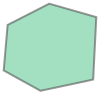

In [128]:
ds_lad[ds_lad['Substation Number'] == target_ds].geometry.values[0]

In [129]:
local_chargers_gdf.loc[local_chargers_gdf.geometry.within(ds_lad[ds_lad['Substation Number'] == target_ds].geometry.values[0])]

,ID,Title,Town,Operator,Operational,Connection_Type,Number_of_Points,Current_Type,Power_KW,Usage,Cost,Latitude,Longitude,geometry


In [130]:
address = "BA1 1LZ" # Chosen as a central location of Bath city

geolocator = Nominatim(user_agent="iyzf20@bath.ac.uk") # Using the Nominatim geolocator from OpenStreetMap

location = geolocator.geocode(address)

loc_lat = location.point.latitude
loc_lon = location.point.longitude

print("Latitude:", loc_lat)
print("Longitude:", loc_lon)

Latitude: 51.38100816666667
Longitude: -2.359801216666667


In [131]:
m1 = folium.Map(location=[loc_lat, loc_lon], tiles='openstreetmap', zoom_start=11)
folium.GeoJson(data = local_chargers_gdf,
               tooltip = folium.features.GeoJsonTooltip(
               fields = ['Title', 'Connection_Type', 'Number_of_Points', 'Current_Type', 'Power_KW', 'Usage'],
               aliases = ['Title:', 'Connection Type:', 'Number of Points:', 'Current Type:', 'Power (kW)', 'Usage']),
              ).add_to(m1)

sim_geo = gpd.GeoSeries(ds_lad[ds_lad['Substation Number'] == target_ds].geometry).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
folium.Popup(ds_lad[ds_lad['Substation Number'] == target_ds]['Substation Number']).add_to(geo_j)
geo_j.add_to(m1)

m1